In [1]:
from Codes import Model, Focal_Loss, Dataset, train_func
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os

In [2]:
folder = "results"
try:
    os.mkdir(folder)
except:
    pass

In [3]:
metadata_folder = '../metadata/'
clinical = pd.read_table(metadata_folder+'clinical.tsv', encoding='utf-8', index_col=1)
clinical = clinical[~clinical.index.duplicated(keep='first')]

manifest = pd.read_table(metadata_folder+'gdc_manifest_20230502_001533.txt')
files = "Data/" + manifest['id'] + '/' + manifest['filename']
clinical_gdc = pd.read_table(metadata_folder+'nationwidechildrens.org_clinical_patient_ov.txt', index_col=1).iloc[2:]

def cs_to_int(cs):
    match cs:
        case "Stage IA":
            return 1
        case "Stage IB":
            return 1
        case 'Stage IC':
            return 1
        case 'Stage IIA':
            return 2
        case 'Stage IIB':
            return 2
        case 'Stage IIC':
            return 2
        case 'Stage IIIA':
            return 3
        case 'Stage IIIB':
            return 3
        case 'Stage IIIC':
            return 3
        case 'Stage IV':
            return 4
        case '[Not Available]':
            return 3
clinical_gdc['clinical_stage'] = clinical_gdc['clinical_stage'].apply(cs_to_int)
manifest['case.id'] = manifest['filename'].apply(lambda x: x[:12])

In [4]:
def get_cBioportal_survival(pfs_path, os_path, dfs_path, dss_path):
    data_pfs = pd.read_table(pfs_path, index_col=1, header=0).dropna()
    data_os = pd.read_table(os_path, index_col=1, header=0).dropna()
    data_dfs = pd.read_table(dfs_path, index_col=1, header=0).dropna()
    data_dss = pd.read_table(dss_path, index_col=1, header=0).dropna()

    data_pfs = data_pfs[~data_pfs.index.duplicated(keep="first")]
    data_pfs["PFS_STATUS"] = [s[0] for s in data_pfs["PFS_STATUS"]]
    data_os["OS_STATUS"] = [s[0] for s in data_os["OS_STATUS"]]
    data_dfs["DFS_STATUS"] = [s[0] for s in data_dfs["DFS_STATUS"]]
    data_dss["DSS_STATUS"] = [s[0] for s in data_dss["DSS_STATUS"]]
    data_dfs = data_dfs[~data_dfs.index.duplicated(keep="first")]
    data_dss = data_dss[~data_dss.index.duplicated(keep="first")]
    data_pfs = data_pfs[~data_pfs.index.duplicated(keep="first")]
    data_os = data_os[~data_os.index.duplicated(keep="first")]
    return data_pfs, data_os, data_dfs, data_dss

pfs_path = metadata_folder+"KM_Plot__Progression_Free__Survival_(months)_pancancer.txt"
os_path = metadata_folder+"KM_Plot__Overall_Survival__(months)_pancancer.txt"
dfs_path = metadata_folder+"KM_Plot__Disease_Free__Survival_(months)_pancancer.txt"
dss_path = metadata_folder+"KM_Plot__Disease-specific_Survival__(months)_pancancer.txt"
ov_pfs, ov_os, ov_dfs, ov_dss = get_cBioportal_survival(pfs_path, os_path, dfs_path, dss_path)

In [229]:
manifest_pfs = manifest.join(ov_pfs, on='case.id', how='inner')
manifest_pfs = manifest_pfs[manifest_pfs['PFS_STATUS']=='1']
patients = manifest_pfs.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')
patients_s1and2 = patients[(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==2)|(patients['clinical_stage']==2)].index
manifest_pfs = manifest_pfs[[p not in patients_s1and2 for p in manifest_pfs['case.id']]]

manifest_os = manifest.join(ov_os, on='case.id', how='inner')
manifest_os = manifest_os[manifest_os['OS_STATUS']=='1']
patients = manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')
patients_s1and2 = patients[(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==2)|(patients['clinical_stage']==2)].index
manifest_os = manifest_os[[p not in patients_s1and2 for p in manifest_os['case.id']]]

In [230]:
manifest_os[["OS_MONTHS"]].median()

OS_MONTHS    35.12
dtype: float64

In [231]:
manifest_pfs[['PFS_MONTHS']].median()

PFS_MONTHS    14.794358
dtype: float64

In [232]:
clinical_features = manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner').columns[1:]
print('Median diagnostic age in months:', manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')['age_at_initial_pathologic_diagnosis'].astype(int).median())

for c in clinical_features:
    print(manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')[['id',c]].groupby(c).count())

Median diagnostic age in months: 60.0
                                                    id
filename                                              
TCGA-04-1331-01A-01-BS1.27aaf831-a80b-4a55-a239...   1
TCGA-04-1332-01A-01-BS1.0f52bd8b-65e8-4648-b6b8...   1
TCGA-04-1337-01A-01-TS1.fcf8e211-01f7-4937-b0b1...   1
TCGA-04-1342-01A-01-TS1.66421418-fc94-4215-9ab1...   1
TCGA-04-1343-01A-01-BS1.ffc80a0b-db70-456c-8e52...   1
...                                                 ..
TCGA-61-2611-11A-01-TS1.1e7c1593-3fc9-4ee1-880d...   1
TCGA-61-2612-01A-01-TS1.99d37374-5619-4342-86df...   1
TCGA-61-2613-01A-01-BS1.a03e1b6b-eb1f-4956-8ed9...   1
TCGA-61-2614-01A-01-TS1.9649012a-36a2-4680-9198...   1
TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA...   1

[335 rows x 1 columns]
                                  id
md5                                 
00a9e933de8248013b246eacbc401a40   1
0121655fd45a5ebb08a166b38f2eb8f3   1
016bd9a4a485515b49b32d5e2f699890   1
0219af3fac02cb8474115c62f415defd   1
0

id  \
1299  9f9d8f37-855c-4878-a7f2-3dec6055dffd   
1362  07f2509c-7db2-4057-98b7-2ee081c7179b   
93    3a9d82e5-4581-4ca3-b04f-694cf666a3de   
471   f7b222ab-93e7-407b-9f60-b4f305b74b1e   
586   d1c2a221-ea41-4ec9-ba49-d504bf0f6f9e   
...                                    ...   
1353  aa112f7a-49f4-4591-974f-198f03c724e9   
1365  07f4054a-7f46-49bc-b63e-02e49387f18d   
670   25ffaa7a-a849-45ff-8ebd-36864a521146   
551   bf13625a-73a5-4dac-9695-f8b7cd82246c   
803   6283f99c-4e0d-4db1-ae30-4982caa6cc83   

                                               filename  \
1299  TCGA-23-1124-01A-01-BS1.bce719cf-462c-418c-864...   
1362  TCGA-04-1530-01A-01-BS1.8cb941db-9ee8-49cc-b0c...   
93    TCGA-25-2399-01A-01-BS1.55932ba7-125d-49c0-bb6...   
471   TCGA-24-1431-01A-01-TS1.56af0d60-12ff-42cd-bf2...   
586   TCGA-24-1923-01A-01-TS1.efa7fe61-eeee-4f33-a76...   
...                                                 ...   
1353  TCGA-25-2401-01A-01-BS1.8c7e8e52-32b5-4abc-831...   
1365  TCGA-24-2023-11A-01-BS1.e147aecb-c7eb-4ff5-b87...   
670   TCGA-13-0768-01A-01-TS1.209a6162-13a3-4fd1-839...   
551   TCGA-61-1916-11A-01-BS1.5214e5c4-99e5-4841-bc2...   
803   TCGA-13-0908-01B-01-TS1.ee2524ac-c719-4a1f-8e3...   

                                   md5       size      state       case.id  \
1299  55bf4fc571b16570c80d6d0291af2cc8  205522237  validated  TCGA-23-1124   
1362  c07a7e30bdb58bb2f9f9c39c7eda7854   97624299  validated  TCGA-04-1530   
93    3e757d7e4b9acc08e4124a2b15faacf9  136658763  validated  TCGA-25-2399   
471   9ec320cd20daa272b72558a83713a127  317511683  validated  TCGA-24-1431   
586   82ec62db31968e5efa1ca98e5e6d9c96  218394369  validated  TCGA-24-1923   
...                                ...        ...        ...           ...   
1353  973c5c88c1186a2fb4e0cc675a242a55  304403467  validated  TCGA-25-2401   
1365  1dd4f4edd761b0ed04d5503e7c60b8da   37460239  validated  TCGA-24-2023   
670   6b8ed300afd958032899dcf0aec057b7  296910693  validated  TCGA-13-0768   
551   b1ad873c0c9a282ea09a9168b2860df6   47775015  validated  TCGA-61-1916   
803   8ea481e380e475dd64e44ffff888333c  282665945  validated  TCGA-13-0908   

     Study ID OS_STATUS  OS_MONTHS  y  
1299  ov_tcga         1      58.08  1  
1362  ov_tcga         1     118.99  1  
93    ov_tcga         1      19.97  0  
471   ov_tcga         1      18.63  0  
586   ov_tcga         1      22.67  0  
...       ...       ...        ... ..  
1353  ov_tcga         1       2.96  0  
1365  ov_tcga         1      44.81  1  
670   ov_tcga         1      58.61  1  
551   ov_tcga         1      15.60  0  
803   ov_tcga         1      60.55  1  

[464 rows x 10 columns]

In [244]:
y_os = (manifest_os[["OS_MONTHS"]]>=36).map(lambda x: 1 if x else 0)
manifest_os['y'] = y_os

image_folder = '../Data/'
files = (image_folder + manifest_os["id"] + '/' + manifest_os["filename"] + "-1.jpg").values
X_train, X_test, y_train, y_test = train_test_split(files, manifest_os['y'], random_state=0)
print("Total number of image:", len(files))
train_dataset = Dataset.MyData_test(X_train, y_train)
train_dataloader = DataLoader(train_dataset,batch_size=1,shuffle=False)
# 5-fold CV with X_train/y_train
cv_files = {}
dataset_sizes = {}
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    # Double training dataset with cropped and augmented images
    manifest_os.loc[y_train.iloc[train_index].index].to_csv(f'training_fold_{i}.csv')
    print(f"Fold {i} train data: {len(train_index)}, val data: {len(val_index)}")
    train_file_2 = [file.replace('-1.jpg', '-2.jpg') for file in X_train[train_index]]
    X_train_double = np.concatenate([X_train[train_index], train_file_2])
    y_fold_train = y_train.iloc[train_index]
    y_train_double = pd.concat([y_fold_train, y_fold_train])
    X_val = X_train[val_index]
    y_val =y_train.iloc[val_index]
    train_dataset = Dataset.MyData_train(X_train_double, y_train_double)
    val_dataset = Dataset.MyData_test(X_val, y_val)
    cv_files[i] = {'train': DataLoader(train_dataset,batch_size=6,shuffle=True,pin_memory=True), 'val': DataLoader(val_dataset,batch_size=3,shuffle=False,pin_memory=True)}
    dataset_sizes[i] = {'train': len(train_dataset), 'val': len(val_dataset)}
# Testing data with X_test/y_test
print(f"Test data: {len(X_test)}")
manifest_os.loc[y_test.index].to_csv(f'testing.csv')
test_dataset = Dataset.MyData_test(X_test, y_test)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

Total number of image: 773
Fold 0 train data: 463, val data: 116
Fold 1 train data: 463, val data: 116
Fold 2 train data: 463, val data: 116
Fold 3 train data: 463, val data: 116
Fold 4 train data: 464, val data: 115
Test data: 194


In [10]:
model_ft = Model.Net()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0002)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Save initial model
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, folder+"/model_initial.pt")

criterion = Focal_Loss.Focal_Loss()

In [ ]:
train_func.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10, folder=folder, folds=[0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4], cv_files=cv_files,dataset_sizes=dataset_sizes)

In [201]:
import torch.nn as nn
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import sklearn
from lifelines import CoxPHFitter
from sksurv import metrics

def evaluate_5CV(test_dataloader, index, folds):
    cv_test_index = index
    cv_predicted_df_dict = {}

    for fold in folds:
        cv_test_predicted_df = pd.DataFrame(np.zeros((len(cv_test_index),3)), index=cv_test_index, columns=['H&E_score','gold','layers'])
        file = np.sort(os.listdir(f"{folder}/{str(fold)}"))[-1] # Get the last model file in the folder
        print(f"Fold {fold} model:", file)
        model_path = f"{folder}/{str(fold)}/{file}"
        checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
        model_test = Model.Net()
        model_test.load_state_dict(checkpoint['model_state_dict'])
        model_test.cuda()
        criterion = nn.CrossEntropyLoss()
        epoch_test = checkpoint['epoch']
        loss_test = checkpoint['loss']
        model_test.eval()

        loss_epoch_test=[]
        y_proba = []
        y_layers = []
        y_gold = []
        y_pred = []
        with torch.no_grad():
            for b, (X, y) in enumerate(test_dataloader):
                outputs, a1, a2 = model_test(X.cuda())
                _, preds = torch.max(outputs, 1)
                y_proba += torch.flatten(outputs[:,1]).cpu().tolist()
                y_gold += y.data.cpu().tolist()
                y_pred += preds.cpu().tolist()
    #             loss = criterion(outputs.float(), torch.tensor([[1,0] if label==0 else [0,1] for label in y_test]).to(device).float())
    #             loss_epoch_test.append(loss.item())

            auc=roc_auc_score(y_gold,y_proba)
            print(f"Fold {fold} AUROC: {auc}")
        cv_test_predicted_df.loc[cv_test_index,'H&E_score'] = y_proba
        cv_test_predicted_df.loc[cv_test_index,'gold'] = y_gold
#         cv_test_predicted_df.loc[cv_test_index,'layers'] = y_layers
        cv_predicted_df_dict[fold] = cv_test_predicted_df
#         result_score_pfs = manifest_pfs.join(cv_test_predicted_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','y','score','gold']].groupby('case.id').mean()
#         result_score_pfs = result_score_pfs[result_score_pfs['PFS_STATUS']==1]
#         result_score_pfs

    # Average the scores of the 5 folds
    temp = cv_test_predicted_df[["H&E_score"]]
    for fold in folds:
        temp["H&E_score"] += cv_predicted_df_dict[fold]["H&E_score"]
    cv_test_predicted_df["H&E_score"] = temp["H&E_score"]/len(folds)
    
    return cv_test_predicted_df

def roc_curve_multi(df_with_score_and_survival, survival_duration_col, survival_status_col, score_col, prediction_durations, lte_or_ste_str):
    fig, ax = plt.subplots(figsize=(8,8))
    for d in prediction_durations:
        if lte_or_ste_str=='<=':
            gold = df_with_score_and_survival[survival_duration_col]<=d
            if score_col == 'Cox_score' or score_col == 'age_at_initial_pathologic_diagnosis':
                scores = df_with_score_and_survival[score_col].astype(float)
            else:
                scores = -1*df_with_score_and_survival[score_col].astype(float)
        elif lte_or_ste_str=='>=':
            gold = df_with_score_and_survival[survival_duration_col]>=d
            if score_col == 'Cox_score' or score_col == 'age_at_initial_pathologic_diagnosis':
                scores = -1*df_with_score_and_survival[score_col].astype(float)
            else:
                scores = df_with_score_and_survival[score_col].astype(float)
        elif lte_or_ste_str=='<':
            gold = df_with_score_and_survival[survival_duration_col]<d
            if score_col == 'Cox_score' or score_col == 'age_at_initial_pathologic_diagnosis':
                scores = df_with_score_and_survival[score_col].astype(float)
            else:
                scores = -1*df_with_score_and_survival[score_col].astype(float)
        elif lte_or_ste_str=='>':
            gold = df_with_score_and_survival[survival_duration_col]>d
            if score_col == 'Cox_score' or score_col == 'age_at_initial_pathologic_diagnosis':
                scores = -1*df_with_score_and_survival[score_col].astype(float)
            else:
                scores = df_with_score_and_survival[score_col].astype(float)
    
    
        
        fpr, tpr, _ = sklearn.metrics.roc_curve(gold, scores)
        auc = round(sklearn.metrics.roc_auc_score(gold, scores), 4)
        ax.plot(fpr,tpr,label=f"{survival_duration_col}{lte_or_ste_str}{d} AUC="+str(auc))
    
#     RocCurveDisplay.from_predictions(
#     gold,
#     scores,
#     name=f"{survival_duration_col}{lte_or_ste_str}{prediction_duration}",
#     color="darkorange",
#     ax=ax
#     )
#     # plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
#     plt.axis("square")
#     plt.xlabel("False Positive Rate")
#     plt.ylabel("True Positive Rate")
#     # plt.title("Receiver Operating Characteristic")
    if score_col == 'H&E_score':
        plt.title("H&E_score")
    elif score_col == 'age_at_initial_pathologic_diagnosis':
        plt.title("Diagnostic_age")
    elif score_col == 'Cox_score':
        plt.title("Cox_score")
    plt.legend()
    plt.show()
    
def correlation_plot(df_with_score_and_survival, survival_duration_col, score_col):  
    plt.scatter(df_with_score_and_survival[survival_duration_col], df_with_score_and_survival[score_col])
    plt.xlabel(survival_duration_col)
    plt.ylabel(score_col)
    r, p = spearmanr(df_with_score_and_survival[survival_duration_col], df_with_score_and_survival[score_col])
    plt.title(f"Spearman R: {r}, p-value: {p}")
    plt.show()

def coxph_multi(df_with_score_and_survival, survival_duration_col, survival_status_col, included_col):
    from lifelines import CoxPHFitter
    cph = CoxPHFitter()
    cph.fit(df_with_score_and_survival[included_col], duration_col=survival_duration_col, event_col=survival_status_col)
    cph.print_summary()
    print(cph.summary)
    cph.plot()
    plt.show()
    return cph
    
def coxph_uni(df_with_score_and_survival, survival_duration_col, survival_status_col, included_col):
    from lifelines import CoxPHFitter
    cph = CoxPHFitter()
    cph.fit(df_with_score_and_survival[included_col], duration_col=survival_duration_col, event_col=survival_status_col)
    cph.print_summary()
    print(cph.summary)
    cph.plot()
    plt.show()
    
    
def model_performance(df_with_score_and_pfs, df_with_score_and_os, cox_pfs=None, cox_os=None):
    correlation_plot(df_with_score_and_pfs, "PFS_MONTHS", "H&E_score")
    correlation_plot(df_with_score_and_os, "OS_MONTHS", "H&E_score")
    correlation_plot(df_with_score_and_pfs, "PFS_MONTHS", "age_at_initial_pathologic_diagnosis")
    correlation_plot(df_with_score_and_os, "OS_MONTHS", "age_at_initial_pathologic_diagnosis")
    roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "H&E_score", [1,3,6,12], "<=")
#     roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "H&E_score", [24,30,36], ">=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "H&E_score", [18,24,30], "<=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "H&E_score", [36,42,60,72], ">=")
    roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "age_at_initial_pathologic_diagnosis", [1,3,6,12], "<=")
#     roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "age_at_initial_pathologic_diagnosis", [24,30,36], ">=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "age_at_initial_pathologic_diagnosis", [18,24,30], "<=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "age_at_initial_pathologic_diagnosis", [36,42,60,72], ">=")

    if cox_os is None:
        cox_os = coxph_multi(df_with_score_and_os, 'OS_MONTHS','OS_STATUS', ['OS_MONTHS','OS_STATUS','H&E_score','age_at_initial_pathologic_diagnosis'])
#         reg_os = LinearRegression().fit(X_os, y_os)
    if cox_pfs is None:
        cox_pfs = coxph_multi(df_with_score_and_pfs, 'PFS_MONTHS','PFS_STATUS', ['PFS_MONTHS','PFS_STATUS','H&E_score','age_at_initial_pathologic_diagnosis'])
#         reg_pfs = LinearRegression().fit(X_pfs, y_pfs)
    df_with_score_and_pfs['Cox_score'] = cox_pfs.predict_partial_hazard(df_with_score_and_pfs[['H&E_score','age_at_initial_pathologic_diagnosis']])
    df_with_score_and_os['Cox_score'] = cox_os.predict_partial_hazard(df_with_score_and_os[['H&E_score','age_at_initial_pathologic_diagnosis']])
    correlation_plot(df_with_score_and_pfs, "PFS_MONTHS", "Cox_score")
    correlation_plot(df_with_score_and_os, "OS_MONTHS", "Cox_score")
    roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "Cox_score", [1,3,6,12], "<=")
#     roc_curve_multi(df_with_score_and_pfs, "PFS_MONTHS", "PFS_STATUS", "Cox_score", [24,30,36], ">=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "Cox_score", [18,24,30], "<=")
    roc_curve_multi(df_with_score_and_os, "OS_MONTHS", "OS_STATUS", "Cox_score", [36,42,60,72], ">=")
    coxph_multi(df_with_score_and_pfs, 'PFS_MONTHS', 'PFS_STATUS', ['PFS_MONTHS', 'PFS_STATUS',"age_at_initial_pathologic_diagnosis","H&E_score"])
    coxph_multi(df_with_score_and_os, 'OS_MONTHS', 'OS_STATUS', ['OS_MONTHS','OS_STATUS',"age_at_initial_pathologic_diagnosis","H&E_score"])
    coxph_uni(df_with_score_and_os, 'OS_MONTHS','OS_STATUS', ['OS_MONTHS','OS_STATUS','H&E_score'])
    coxph_uni(df_with_score_and_pfs, 'PFS_MONTHS','PFS_STATUS', ['PFS_MONTHS','PFS_STATUS','H&E_score'])
    coxph_uni(df_with_score_and_os, 'OS_MONTHS','OS_STATUS', ['OS_MONTHS','OS_STATUS','age_at_initial_pathologic_diagnosis'])
    coxph_uni(df_with_score_and_pfs, 'PFS_MONTHS','PFS_STATUS', ['PFS_MONTHS','PFS_STATUS','age_at_initial_pathologic_diagnosis'])
    # print('PFS c-index',metrics.concordance_index_censored(df_with_score_and_pfs['PFS_STATUS'].apply(lambda x: True if x==1 else False).values,df_with_score_and_pfs['PFS_MONTHS'].values,(df_with_score_and_pfs['Cox_score']).values))
    # print('OS c-index',metrics.concordance_index_censored(df_with_score_and_os['OS_STATUS'].apply(lambda x: True if x==1 else False).values,df_with_score_and_os['OS_MONTHS'].values,(df_with_score_and_os['Cox_score']).values))
    return cox_os, cox_pfs


from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

def kmplot(T, E, L, title, xlabel, ylabel):
    kmf = KaplanMeierFitter()
    for i,t in enumerate(T):
        kmf.fit(t, E[i], label=L[i])
        ax = kmf.plot_survival_function()
    plt.title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

def kmplots(df_os, df_pfs, score_col):
    if score_col == 'age_at_initial_pathologic_diagnosis':
        title = 'Age'
    else:
        title = score_col
    t_os=np.quantile(df_os[score_col],0.5)
    t_pfs=np.quantile(df_pfs[score_col],0.5)
    t1_os=np.quantile(df_os[score_col],0.3)
    t2_os=np.quantile(df_os[score_col],0.7)
    t1_pfs=np.quantile(df_pfs[score_col],0.3)
    t2_pfs=np.quantile(df_pfs[score_col],0.7)
    print(t_pfs)
    
    
    T1 = df_os[df_os[score_col]>t_os]['OS_MONTHS']
    T2 = df_os[df_os[score_col]<=t_os]['OS_MONTHS']
    E1 = df_os[df_os[score_col]>t_os]['OS_STATUS']
    E2 = df_os[df_os[score_col]<=t_os]['OS_STATUS']
    results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmplot([T1,T2], [E1,E2], [f"High {title}", f"Low {title}"], "OS, $\it{p}$-value:" +f"{results.p_value:.3e}","OS, months","Proportion survival")

    kmf = KaplanMeierFitter()
    T1 = df_pfs[df_pfs[score_col]>t_pfs]['PFS_MONTHS']
    T2 = df_pfs[df_pfs[score_col]<=t_pfs]['PFS_MONTHS']
    E1 = df_pfs[df_pfs[score_col]>t_pfs]['PFS_STATUS']
    E2 = df_pfs[df_pfs[score_col]<=t_pfs]['PFS_STATUS']
    results = logrank_test(T1, T2, event_observed_A=E1, event_observed_B=E2)
    kmplot([T1,T2], [E1,E2], [f"High {title}", f"Low {title}"], "PFS, $\it{p}$-value:"+ f"{results.p_value:.3e}","PFS, months","Proportion survival")

    T1 = df_pfs[df_pfs[score_col]<=t1_pfs]['PFS_MONTHS']
    T2 = df_pfs[(df_pfs[score_col]>t1_pfs)&(df_pfs[score_col]<=t2_pfs)]['PFS_MONTHS']
    T3 = df_pfs[df_pfs[score_col]>t2_pfs]['PFS_MONTHS']
    E1 = df_pfs[df_pfs[score_col]<=t1_pfs]['PFS_STATUS']
    E2 = df_pfs[(df_pfs[score_col]>t1_pfs)&(df_pfs[score_col]<=t2_pfs)]['PFS_STATUS']
    E3 = df_pfs[df_pfs[score_col]>t2_pfs]['PFS_STATUS']
    results = logrank_test(T1, T3, event_observed_A=E1, event_observed_B=E3)
    kmplot([T1,T2,T3], [E1,E2,E3], [f"Q1 {title}",f"Q2 {title}",f"Q3 {title}"], "PFS, $\it{p}$-value (Q1 vs Q3):" + f"{results.p_value:.3e}","PFS, months","Proportion survival")

    T1 = df_os[df_os[score_col]<=t1_os]['OS_MONTHS']
    T2 = df_os[(df_os[score_col]>t1_os)&(df_os[score_col]<=t2_os)]['OS_MONTHS']
    T3 = df_os[df_os[score_col]>t2_os]['OS_MONTHS']
    E1 = df_os[df_os[score_col]<=t1_os]['OS_STATUS']
    E2 = df_os[(df_os[score_col]>t1_os)&(df_os[score_col]<=t2_os)]['OS_STATUS']
    E3 = df_os[df_os[score_col]>t2_os]['OS_STATUS']
    results = logrank_test(T1, T3, event_observed_A=E1, event_observed_B=E3)
    kmplot([T1,T2,T3], [E1,E2,E3], [f"Q1 {title}",f"Q2 {title}",f"Q3 {title}"], "OS, $\it{p}$-value (Q1 vs Q3):" + f"{results.p_value:.3e}","OS, months","Proportion survival")

In [127]:
tcga_train_df = evaluate_5CV(train_dataloader, y_train.index, folds=[0,1,2,3,4])
tcga_train_df

Fold 0 model: epoch_09loss0.039871_AUROC_0.704545.pt
Fold 0 AUROC: 0.7459642651849012
Fold 1 model: epoch_09loss0.041579_AUROC_0.687184.pt
Fold 1 AUROC: 0.7893993102126844
Fold 2 model: epoch_03loss0.043594_AUROC_0.628121.pt
Fold 2 AUROC: 0.7131634412722743
Fold 3 model: epoch_09loss0.039309_AUROC_0.702508.pt
Fold 3 AUROC: 0.7322283962444913
Fold 4 model: epoch_09loss0.041122_AUROC_0.758620.pt
Fold 4 AUROC: 0.7832199655106342


/tmp/ipykernel_113953/97758563.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["H&E_score"] += cv_predicted_df_dict[fold]["H&E_score"]


H&E_score  gold  layers
102    0.702743   1.0     0.0
1299   0.609272   1.0     0.0
1362   0.694816   1.0     0.0
93     0.452080   0.0     0.0
471    0.587850   0.0     0.0
...         ...   ...     ...
1353   0.468258   0.0     0.0
1365   0.556119   1.0     0.0
670    0.626993   1.0     0.0
551    0.569255   0.0     0.0
803    0.689633   1.0     0.0

[579 rows x 3 columns]

In [128]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_train_score_pfs = manifest_pfs.join(tcga_train_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_pfs = result_train_score_pfs[result_train_score_pfs['PFS_STATUS']==1]
result_train_score_pfs
result_train_score_pfs_clinical = result_train_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_train_score_os = manifest_os.join(tcga_train_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_os = result_train_score_os[result_train_score_os['OS_STATUS']==1]
result_train_score_os_clinical = result_train_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

In [129]:
result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)
result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

In [167]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_train_score_pfs = manifest_pfs.join(tcga_train_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_pfs = result_train_score_pfs[result_train_score_pfs['PFS_STATUS']==1]
result_train_score_pfs
result_train_score_pfs_clinical = result_train_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_train_score_os = manifest_os.join(tcga_train_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_os = result_train_score_os[result_train_score_os['OS_STATUS']==1]
result_train_score_os_clinical = result_train_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)
result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

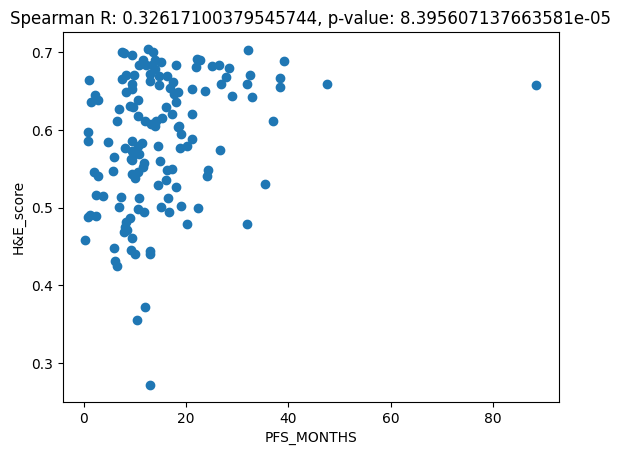

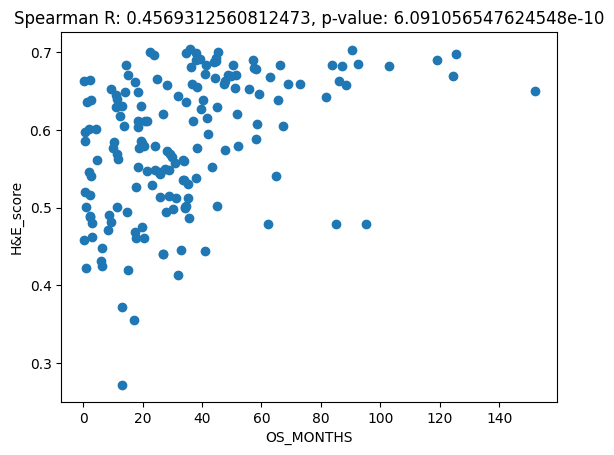

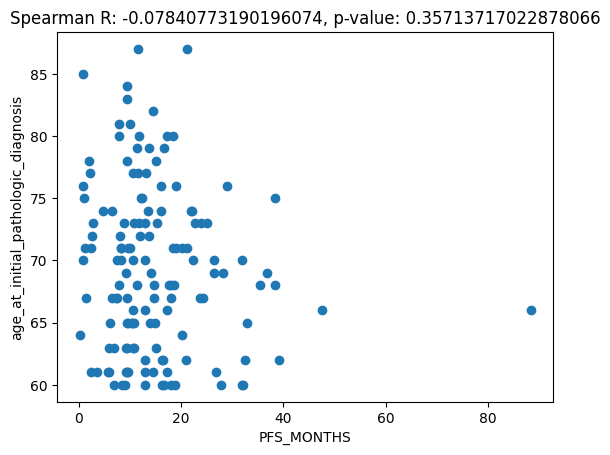

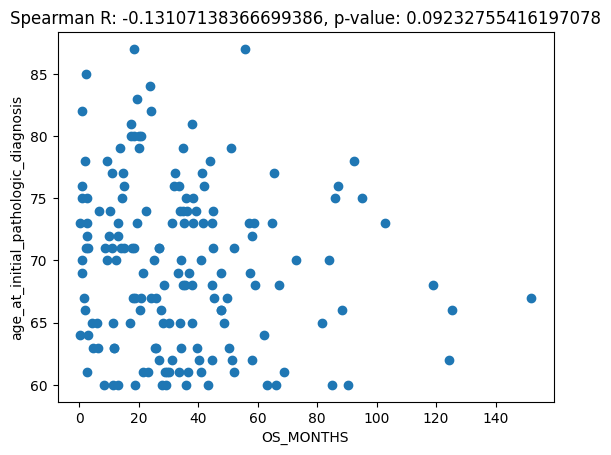

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

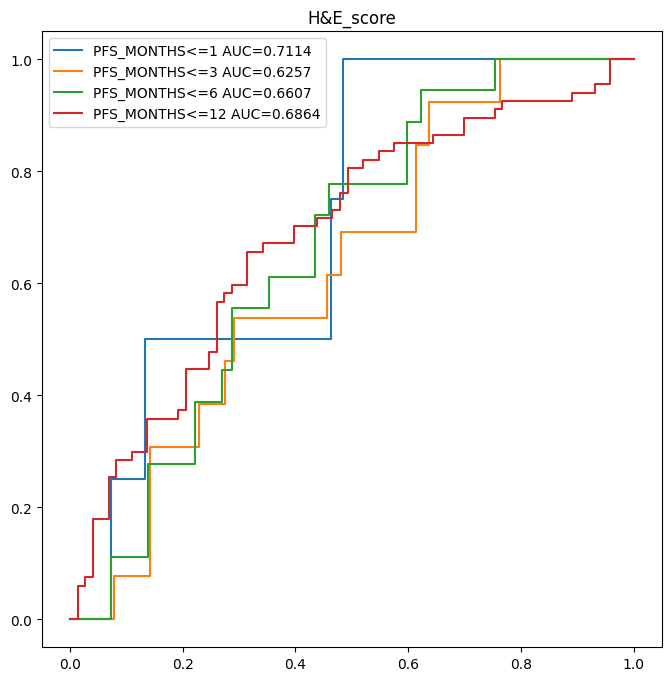

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

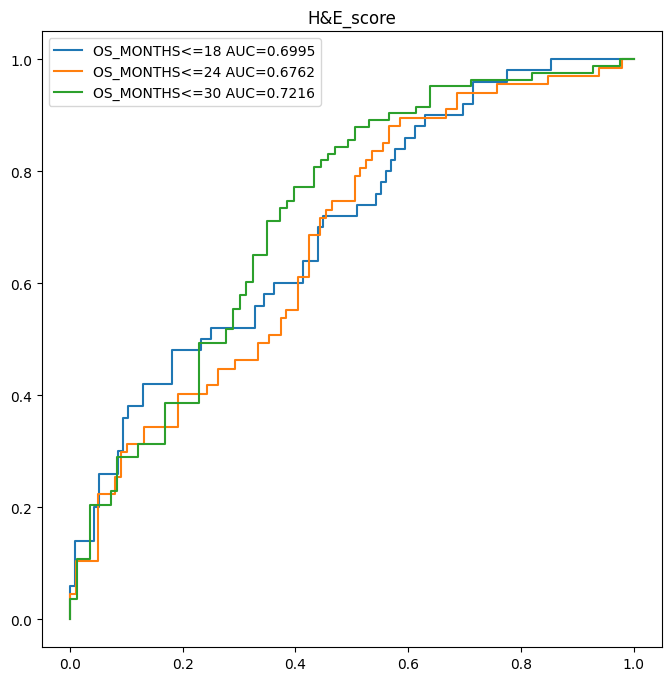

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

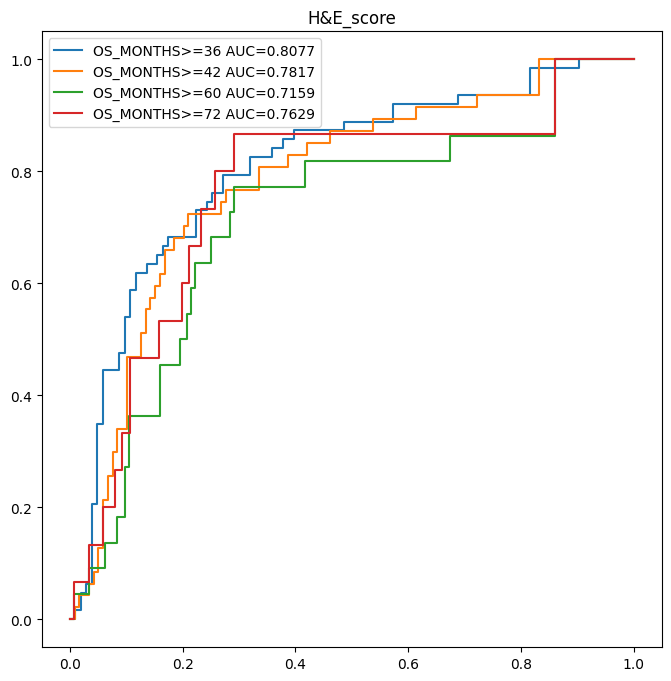

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

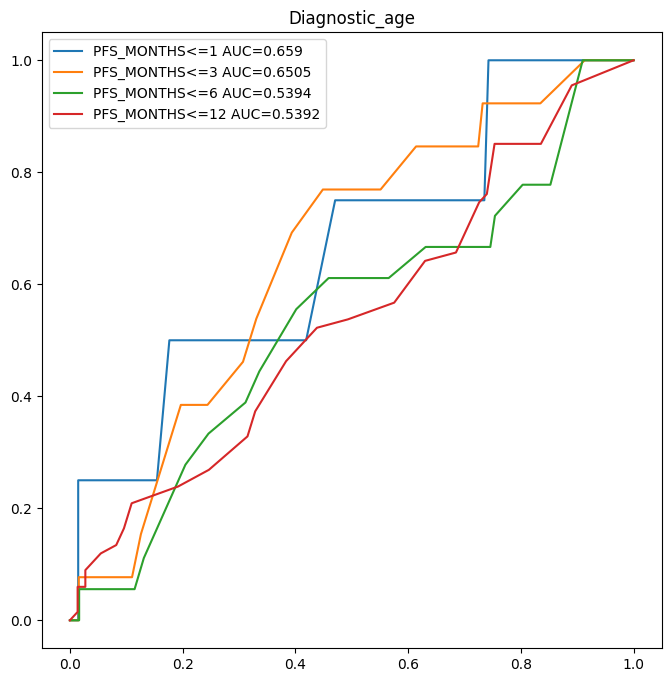

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

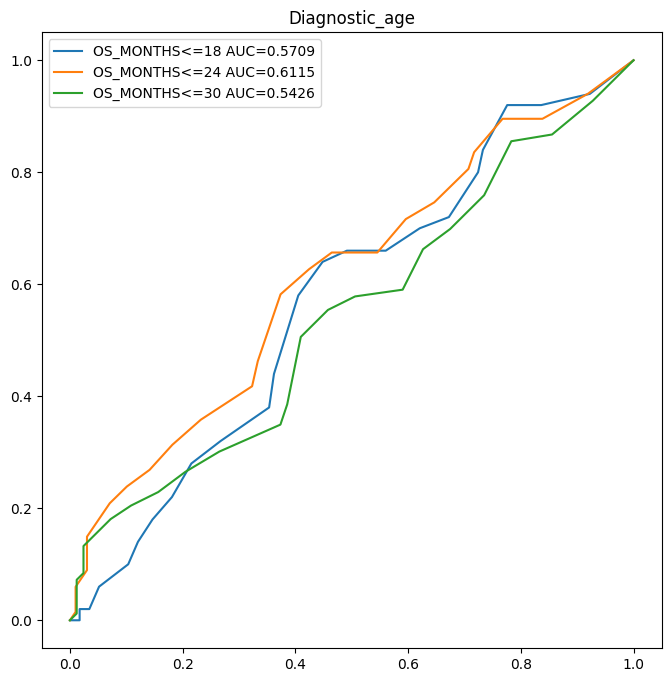

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

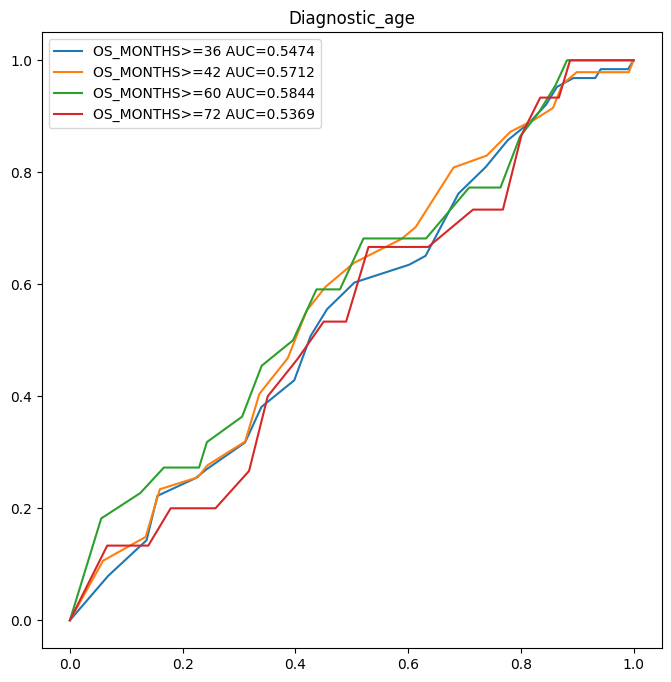

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -667.04
         time fit was run = 2023-11-28 20:47:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -5.66       0.00       0.91            -7.45            -3.87                 0.00                 0.02
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.00             0.05                 1.00                 1.05

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -6.21 <0.005      30.78
age_at_initial_pathologic_diagnosis     0.00  2.21   0.03       5.21
---
Concordance = 0.67
Partial AIC = 1338.08
log-likelihood ratio test = 38.05 on 2 df
-log2(p) of ll-ratio test = 27.45

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -5.662601   0.003473  0.912361   
age_at_initial_pathologic_diagnosis  0.027010   1.027378  0.012222   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -7.450795       -3.874408   
age_at_initial_pathologic_diagnosis        0.003056        0.050964   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.000581             0.020767   
age_at_initial_pathologic_diagnosis             1.003061             1.052285   

                                     cmp to         z             p   -log2(p)  
covariate                   

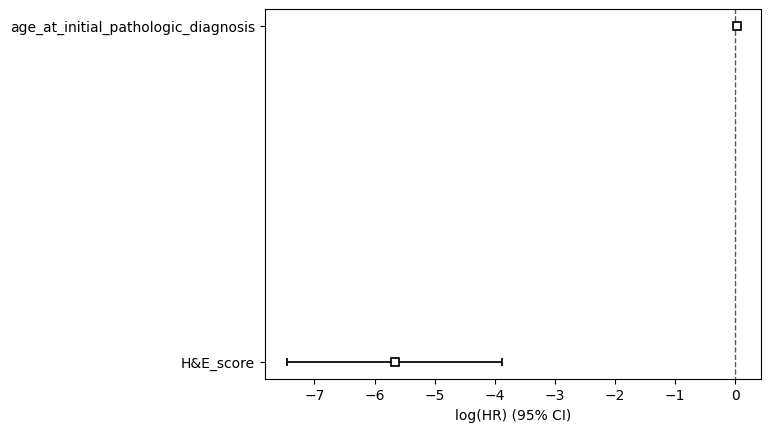

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -544.50
         time fit was run = 2023-11-28 20:47:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -4.76       0.01       1.04            -6.80            -2.72                 0.00                 0.07
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -4.57 <0.005      17.67
age_at_initial_pathologic_diagnosis     0.00  2.43   0.02       6.04
---
Concordance = 0.61
Partial AIC = 1093.01
log-likelihood ratio test = 21.43 on 2 df
-log2(p) of ll-ratio test = 15.46

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -4.761955   0.008549  1.041324   
age_at_initial_pathologic_diagnosis  0.033497   1.034064  0.013802   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -6.802912       -2.720998   
age_at_initial_pathologic_diagnosis        0.006444        0.060549   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.001111             0.065809   
age_at_initial_pathologic_diagnosis             1.006465             1.062419   

                                     cmp to         z         p   -log2(p)  
covariate                       

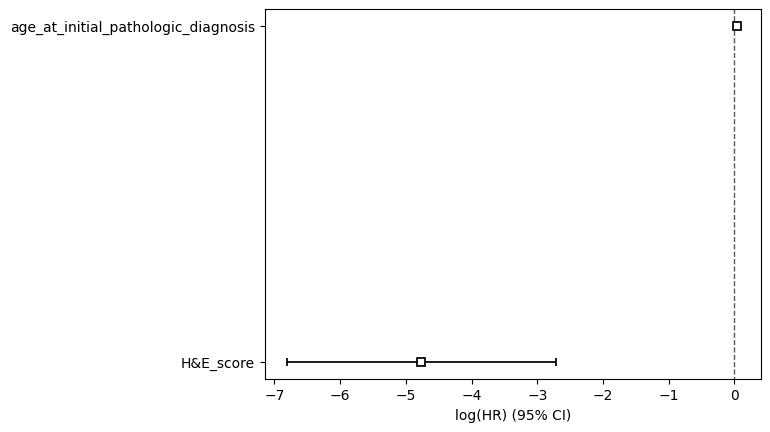

/tmp/ipykernel_113953/2759611059.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_pfs['Cox_score'] = cox_pfs.predict_partial_hazard(df_with_score_and_pfs[['H&E_score','age_at_initial_pathologic_diagnosis']])
/tmp/ipykernel_113953/2759611059.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_os['Cox_score'] = cox_os.predict_partial_hazard(df_with_score_and_os[['H&E_score','age_at_initial_pathologic_diagnosis']])


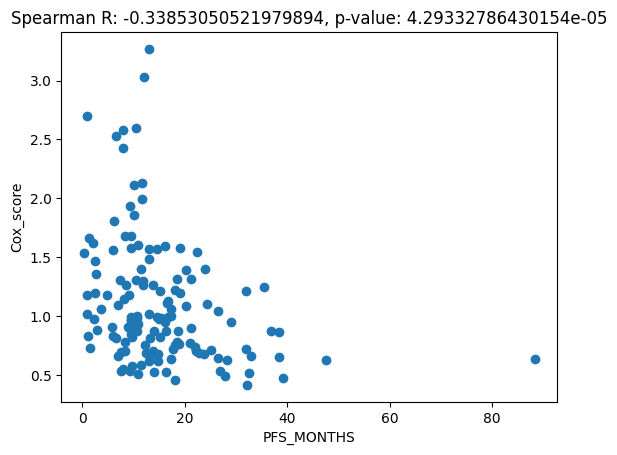

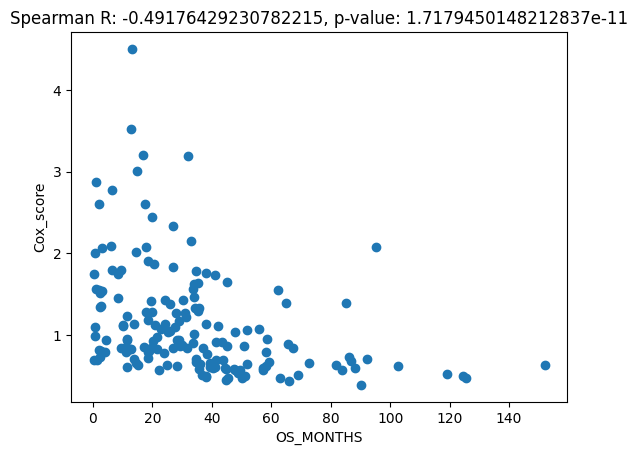

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

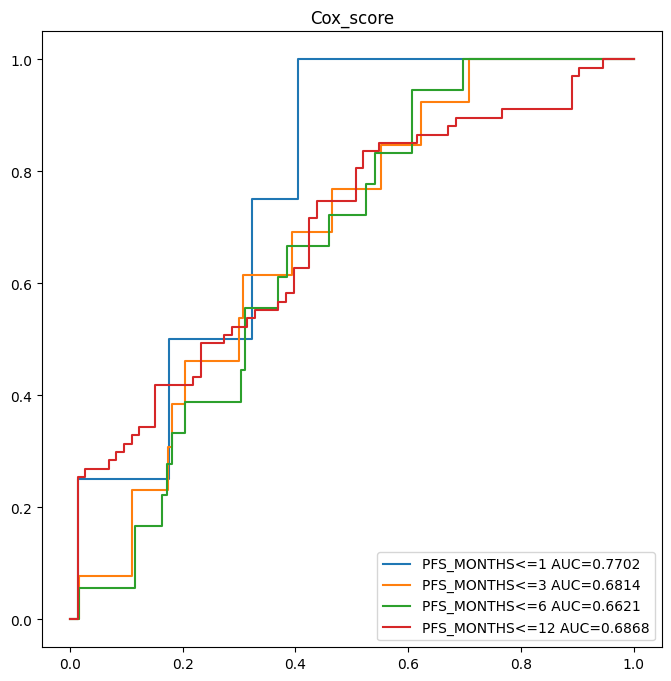

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

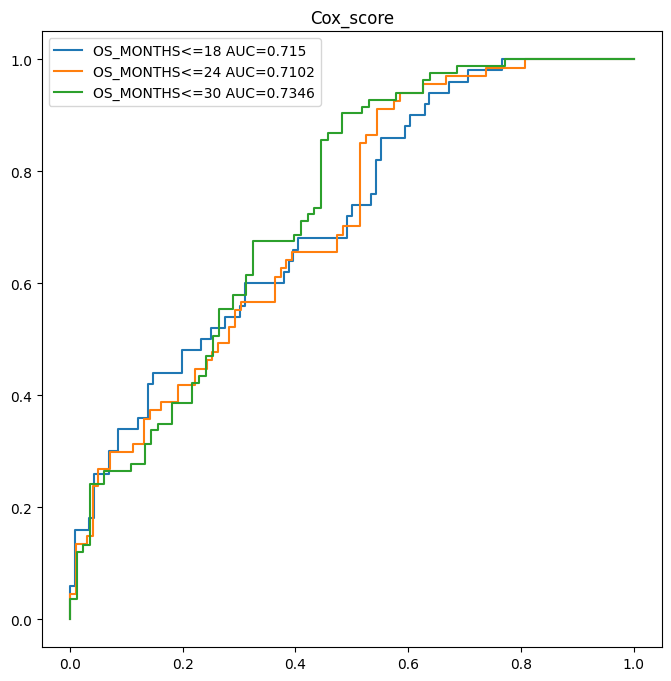

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

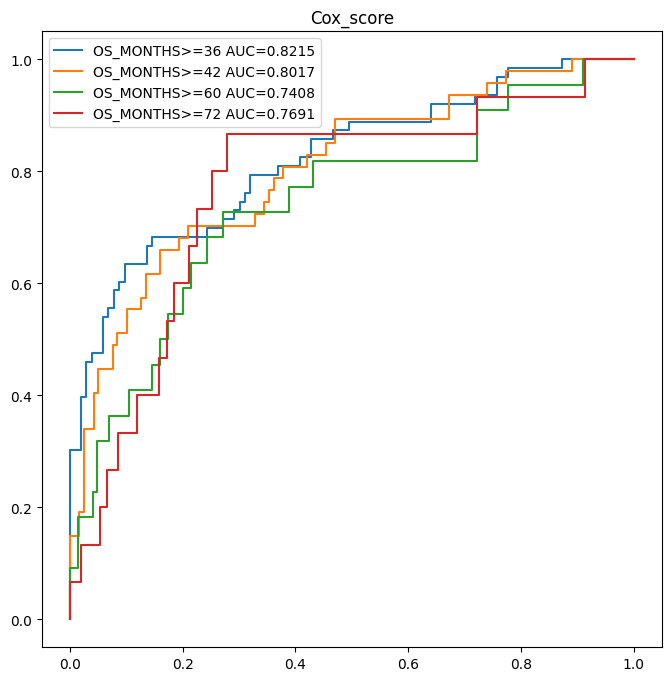

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -544.50
         time fit was run = 2023-11-28 20:47:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
H&E_score                            -4.76       0.01       1.04            -6.80            -2.72                 0.00                 0.07

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.43   0.02       6.04
H&E_score                               0.00 -4.57 <0.005      17.67
---
Concordance = 0.61
Partial AIC = 1093.01
log-likelihood ratio test = 21.43 on 2 df
-log2(p) of ll-ratio test = 15.46

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.033497   1.034064  0.013802   
H&E_score                           -4.761955   0.008549  1.041324   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.006444        0.060549   
H&E_score                                 -6.802912       -2.720998   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.006465             1.062419   
H&E_score                                       0.001111             0.065809   

                                     cmp to         z         p   -log2(p)  
covariate                       

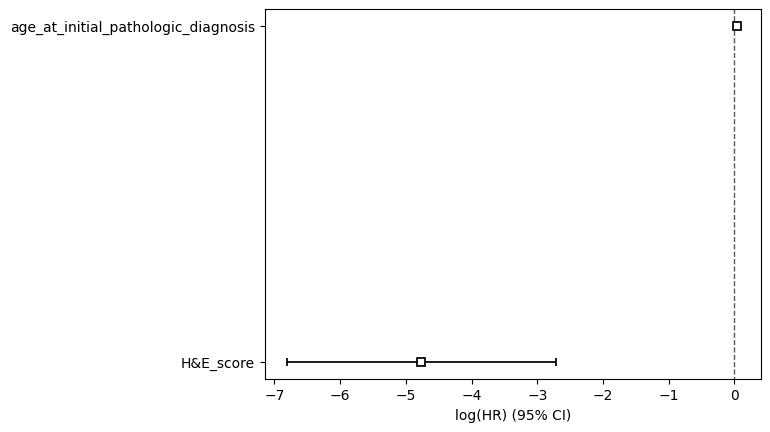

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -667.04
         time fit was run = 2023-11-28 20:47:31 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
H&E_score                            -5.66       0.00       0.91            -7.45            -3.87                 0.00                 0.02

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.21   0.03       5.21
H&E_score                               0.00 -6.21 <0.005      30.78
---
Concordance = 0.67
Partial AIC = 1338.08
log-likelihood ratio test = 38.05 on 2 df
-log2(p) of ll-ratio test = 27.45

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.027010   1.027378  0.012222   
H&E_score                           -5.662601   0.003473  0.912361   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.003056        0.050964   
H&E_score                                 -7.450795       -3.874408   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.003061             1.052285   
H&E_score                                       0.000581             0.020767   

                                     cmp to         z             p   -log2(p)  
covariate                   

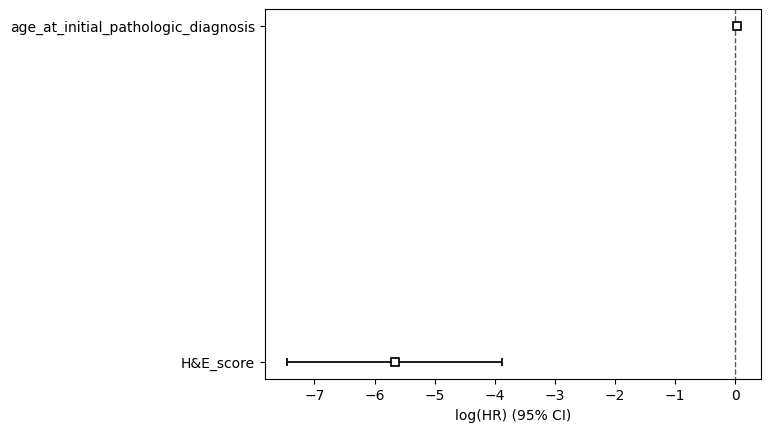

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -669.45
         time fit was run = 2023-11-28 20:47:31 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -5.44       0.00       0.90            -7.21            -3.67                 0.00                 0.03

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -6.02 <0.005      29.09
---
Concordance = 0.65
Partial AIC = 1340.89
log-likelihood ratio test = 33.24 on 1 df
-log2(p) of ll-ratio test = 26.87

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -5.436808   0.004353  0.903272       -7.207188       -3.666428   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.000741             0.025568     0.0 -6.019017   

                      p  -log2(p)  
covariate                          
H&E_score  1.754796e-09  29.08605  


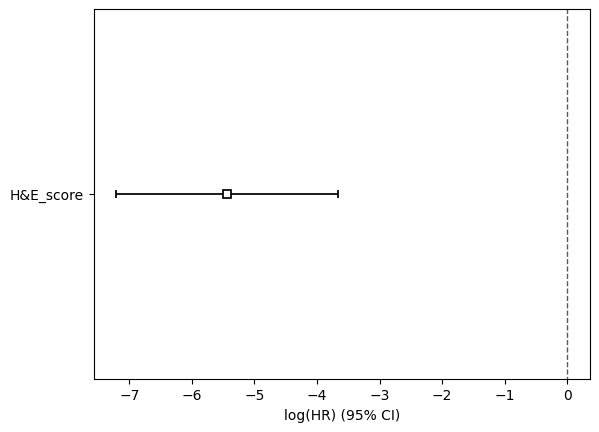

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -547.36
         time fit was run = 2023-11-28 20:47:32 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -4.10       0.02       0.98            -6.03            -2.17                 0.00                 0.11

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -4.17 <0.005      15.02
---
Concordance = 0.61
Partial AIC = 1096.73
log-likelihood ratio test = 15.71 on 1 df
-log2(p) of ll-ratio test = 13.73

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -4.099773   0.016576  0.982455        -6.02535       -2.174196   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.002417               0.1137     0.0 -4.172986   

                 p   -log2(p)  
covariate                      
H&E_score  0.00003  15.021637  


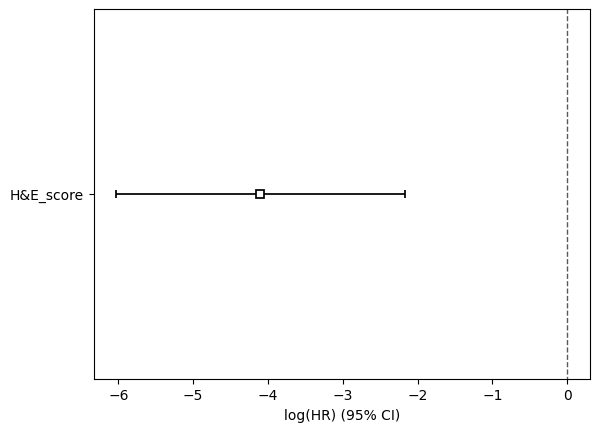

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -684.76
         time fit was run = 2023-11-28 20:47:32 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.00             0.04                 1.00                 1.05

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.62 0.10       3.26
---
Concordance = 0.54
Partial AIC = 1371.52
log-likelihood ratio test = 2.61 on 1 df
-log2(p) of ll-ratio test = 3.23

                                     coef  exp(coef)  se(coef)  \
covariate                                                        
age_at_initial_pathologic_diagnosis  0.02   1.020201  0.012312   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.004131        0.044131   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.995878             1.045119   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.624465  0.104277  3.261512  


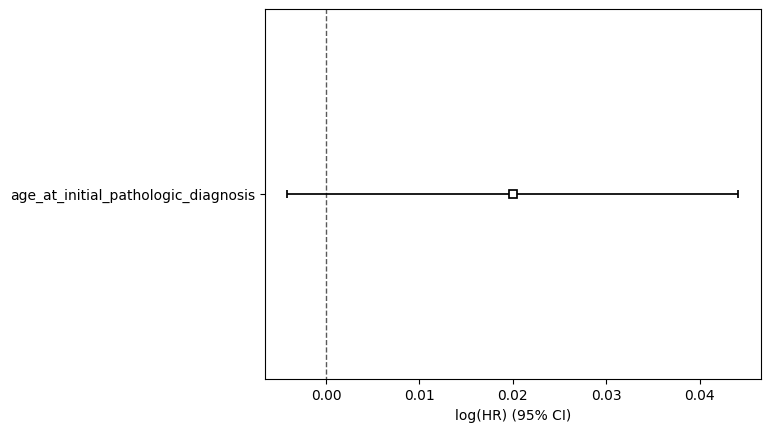

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -554.12
         time fit was run = 2023-11-28 20:47:32 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.50 0.13       2.90
---
Concordance = 0.53
Partial AIC = 1110.23
log-likelihood ratio test = 2.21 on 1 df
-log2(p) of ll-ratio test = 2.87

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.020311   1.020519  0.013541   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.006229        0.046852   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis              0.99379             1.047966   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.499961  0.133624  2.903744  


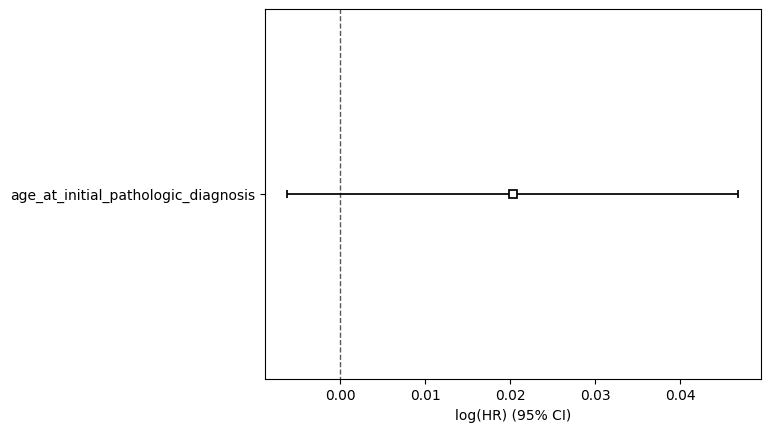

In [227]:
train_cox_os, train_cox_pfs = model_performance(result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60], result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60])

59.5


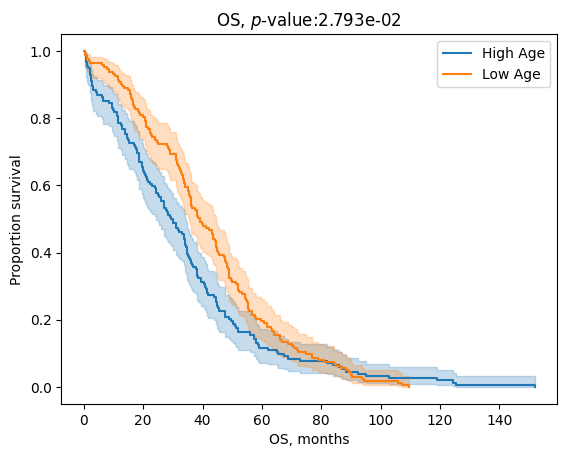

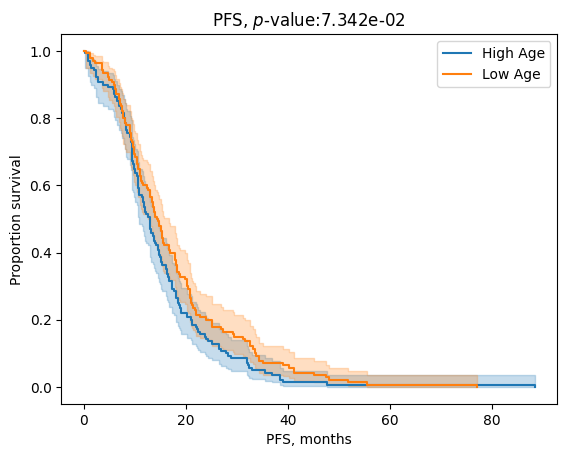

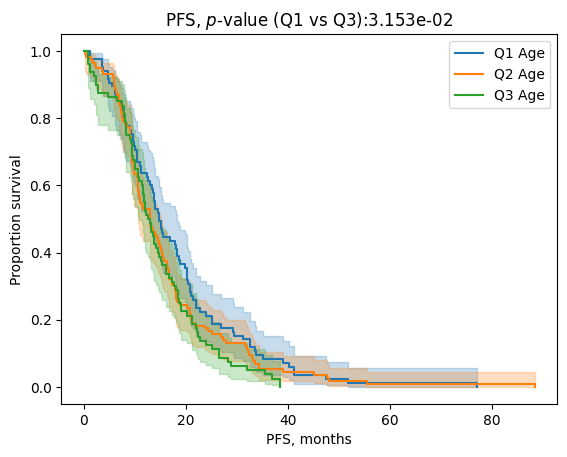

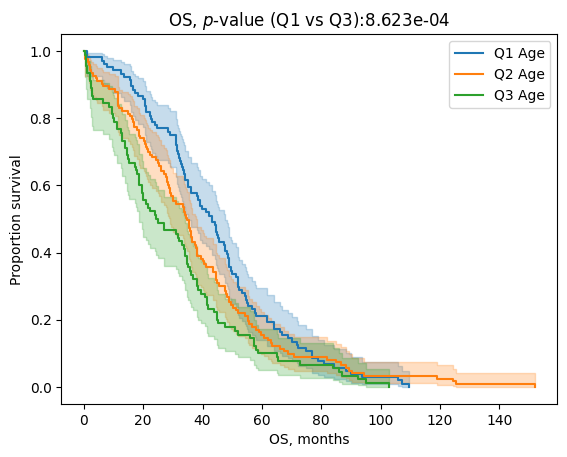

In [206]:
kmplots(result_train_score_os_clinical,result_train_score_pfs_clinical,'age_at_initial_pathologic_diagnosis')

70.0


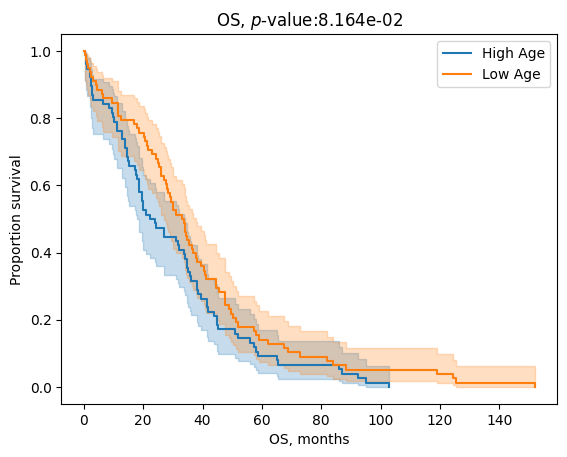

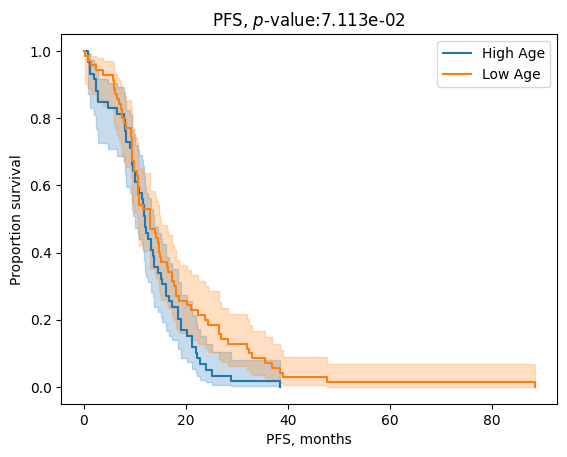

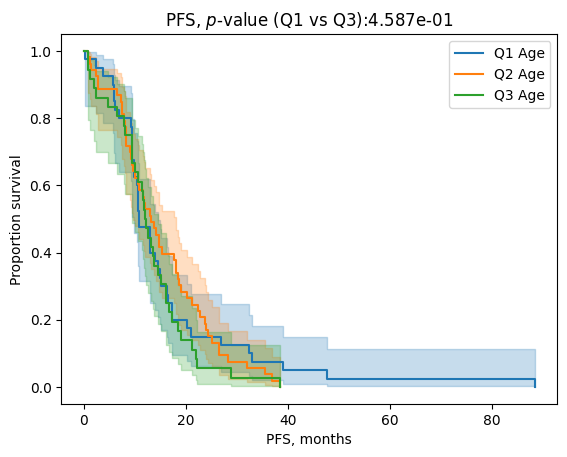

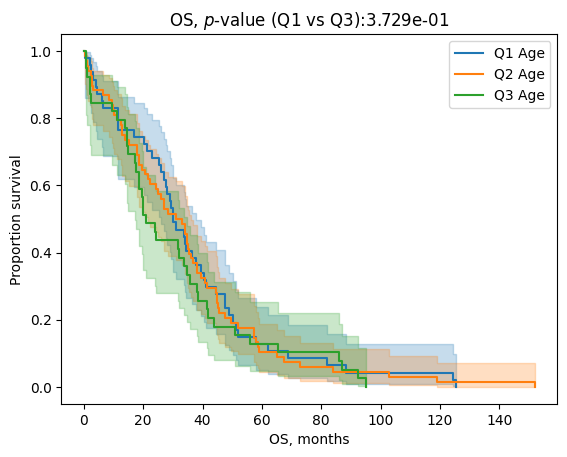

In [220]:
kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'age_at_initial_pathologic_diagnosis')

0.6005383039514224


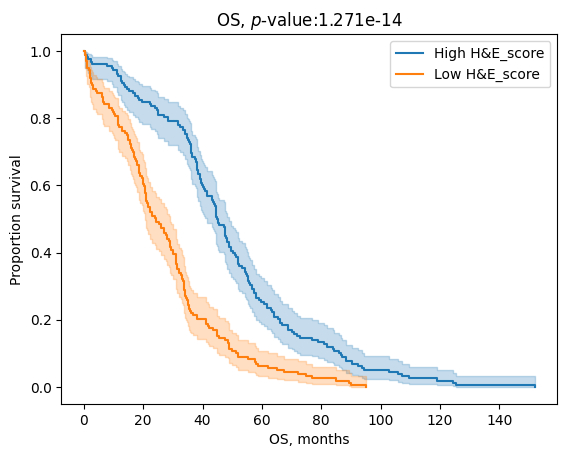

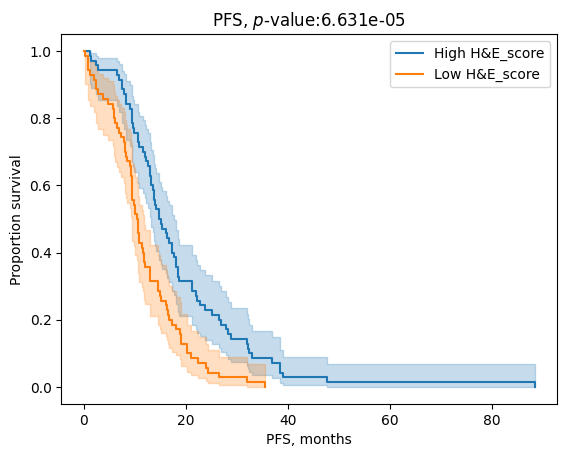

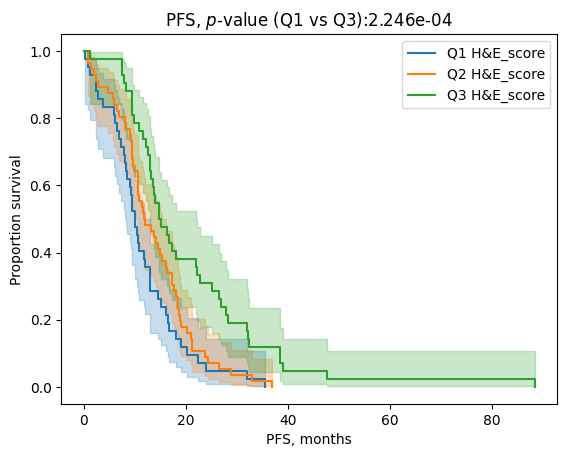

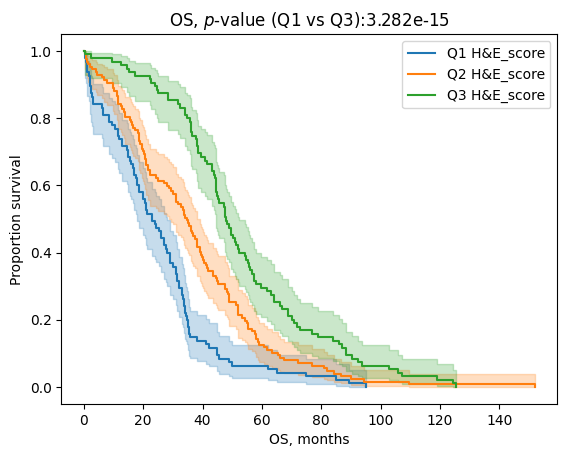

In [226]:
kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>0],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'H&E_score')

1.1351024431143986


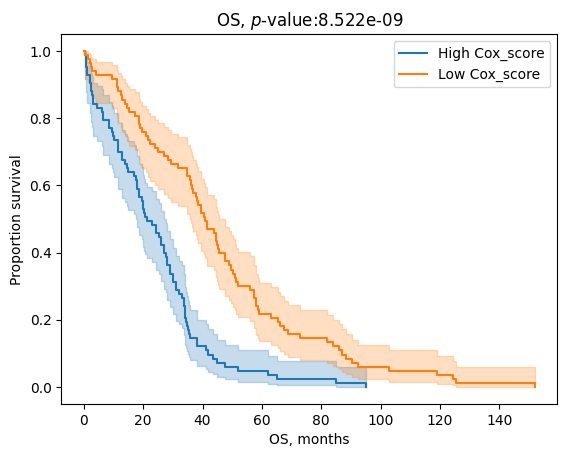

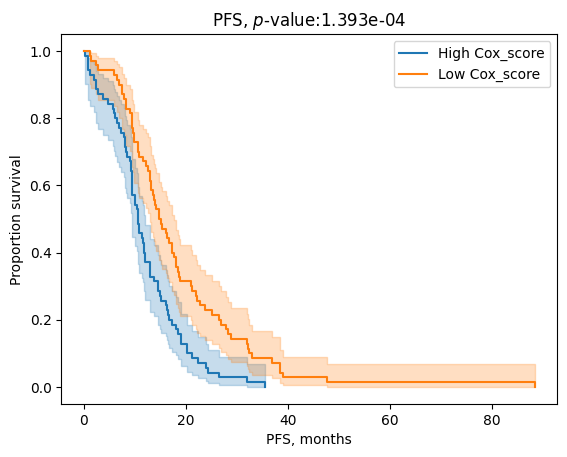

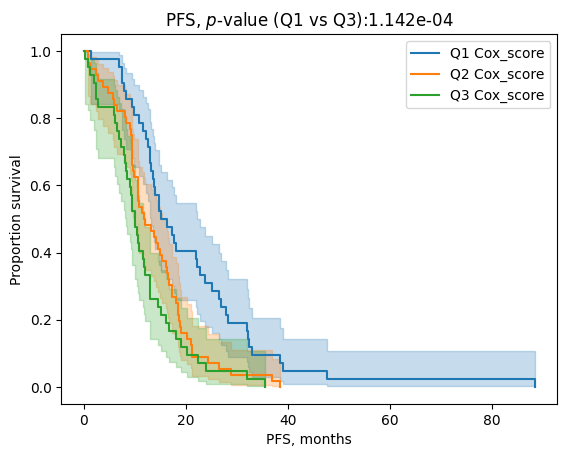

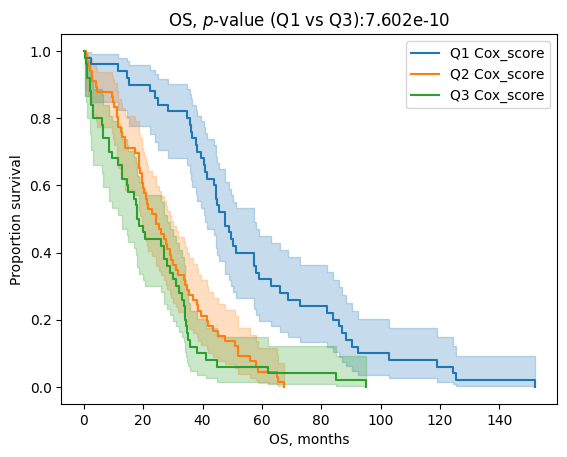

In [225]:
kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'Cox_score')

In [133]:
tcga_test_df = evaluate_5CV(test_dataloader, y_test.index, [0,1,2,3,4])
tcga_test_df

Fold 0 model: epoch_09loss0.039871_AUROC_0.704545.pt
Fold 0 AUROC: 0.6527423469387755
Fold 1 model: epoch_09loss0.041579_AUROC_0.687184.pt
Fold 1 AUROC: 0.5932185374149659
Fold 2 model: epoch_03loss0.043594_AUROC_0.628121.pt
Fold 2 AUROC: 0.6364795918367347
Fold 3 model: epoch_09loss0.039309_AUROC_0.702508.pt
Fold 3 AUROC: 0.6612457482993197
Fold 4 model: epoch_09loss0.041122_AUROC_0.758620.pt
Fold 4 AUROC: 0.6647534013605442


/tmp/ipykernel_113953/97758563.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["H&E_score"] += cv_predicted_df_dict[fold]["H&E_score"]


H&E_score  gold  layers
849    0.513836   0.0     0.0
1061   0.664161   0.0     0.0
341    0.655241   0.0     0.0
6      0.570117   0.0     0.0
535    0.686475   1.0     0.0
...         ...   ...     ...
44     0.613381   0.0     0.0
54     0.537423   1.0     0.0
287    0.700850   1.0     0.0
355    0.546572   1.0     0.0
213    0.499194   0.0     0.0

[194 rows x 3 columns]

In [195]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_score_pfs = manifest_pfs.join(tcga_test_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_score_pfs = result_score_pfs[result_score_pfs['PFS_STATUS']==1]
result_score_pfs
result_score_pfs_clinical = result_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')
result_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_score_os = manifest_os.join(tcga_test_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_score_os = result_score_os[result_score_os['OS_STATUS']==1]
result_score_os
result_score_os_clinical = result_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')
result_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

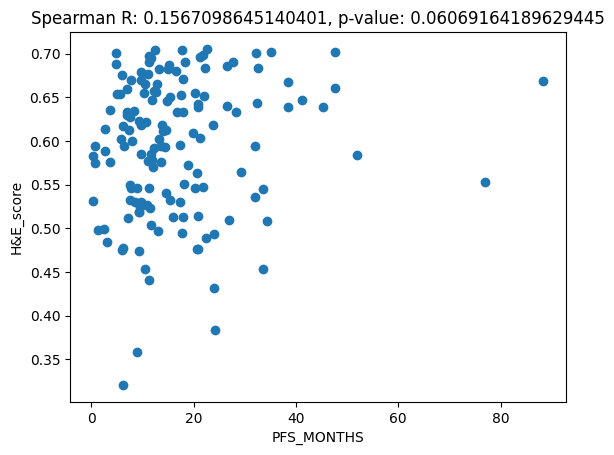

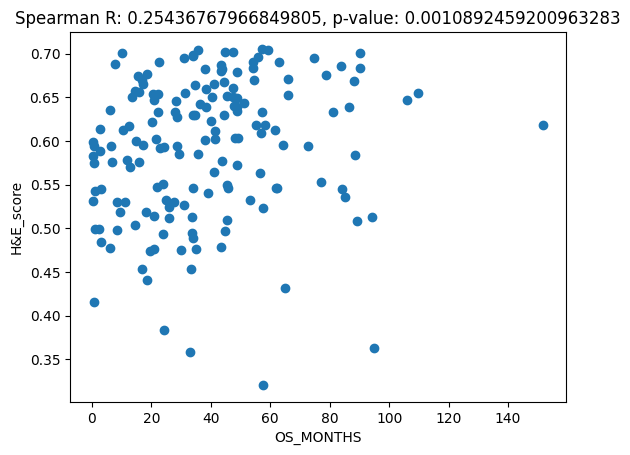

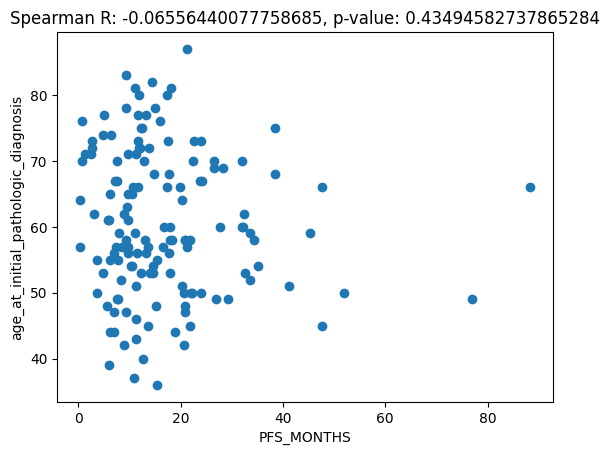

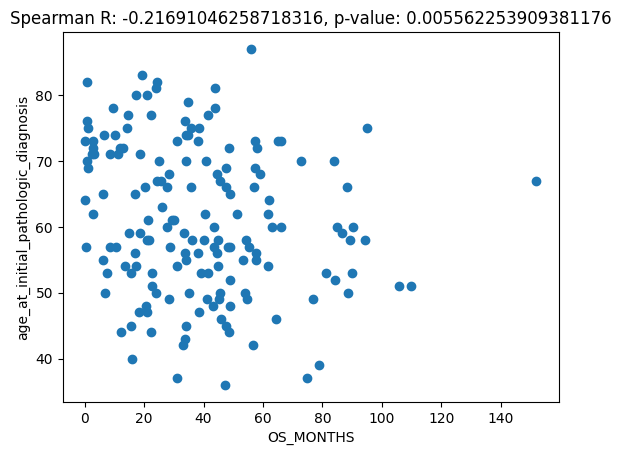

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

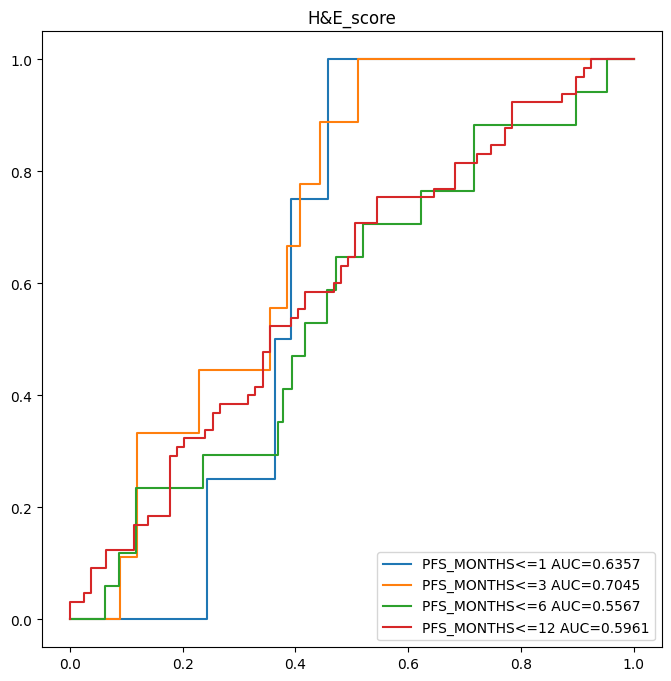

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

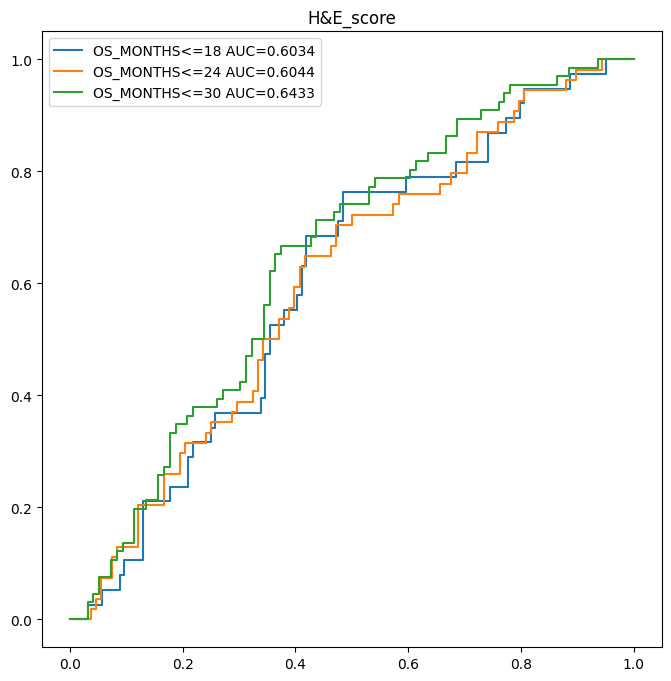

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

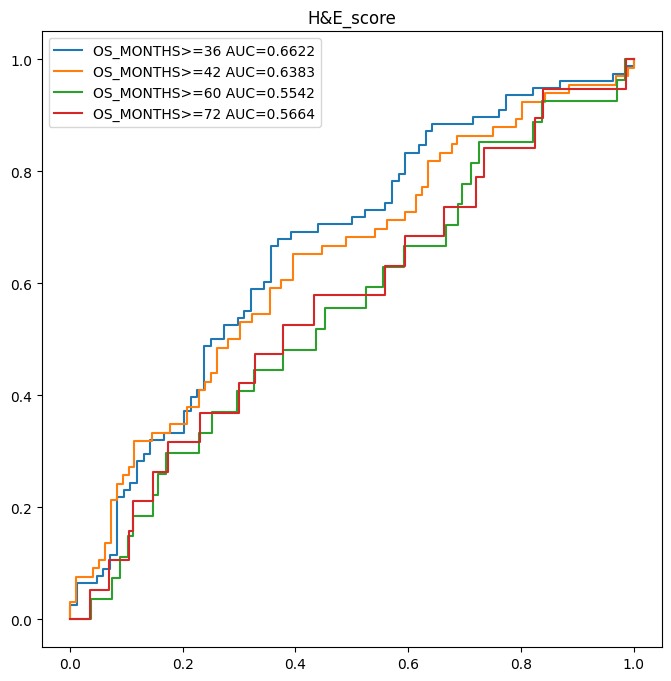

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

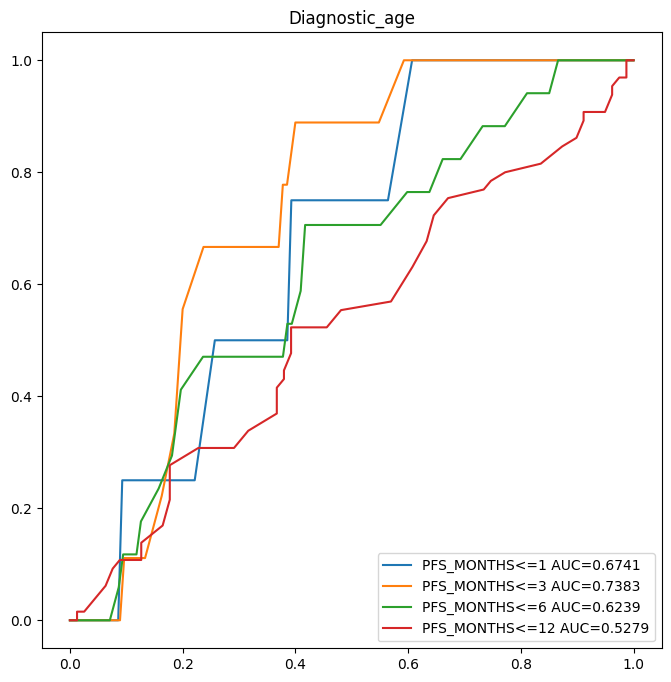

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

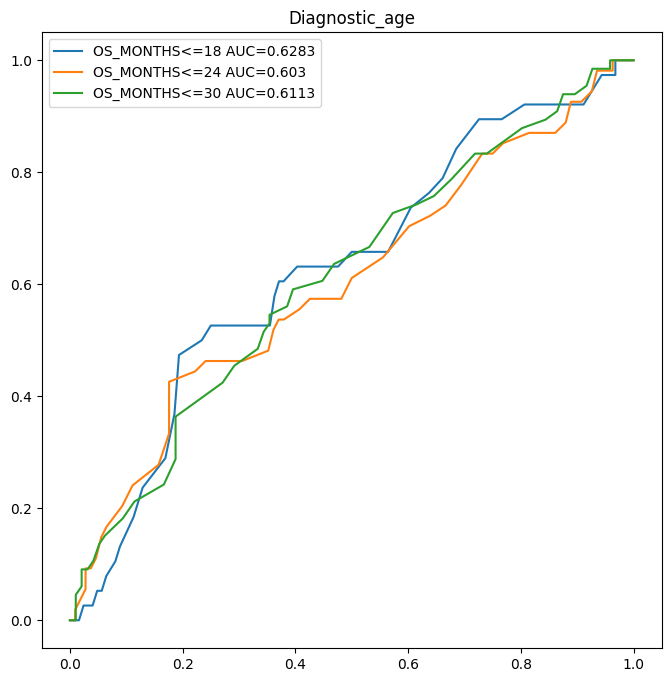

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

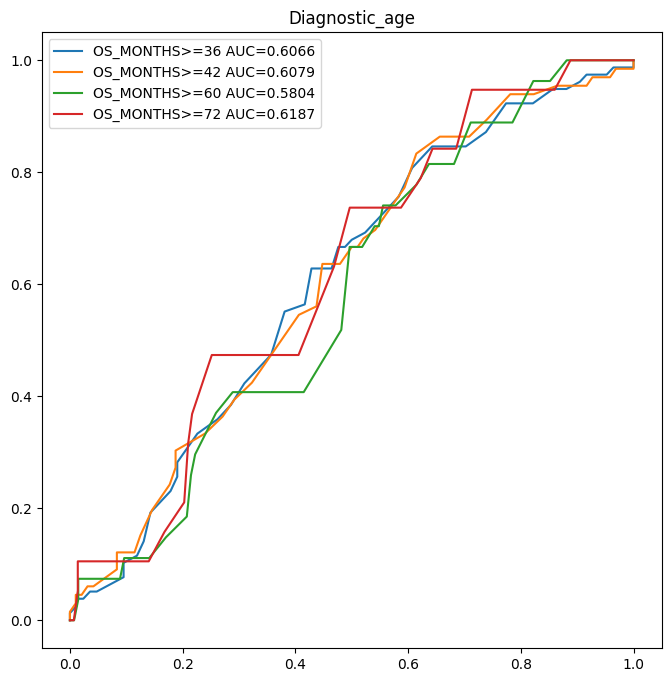

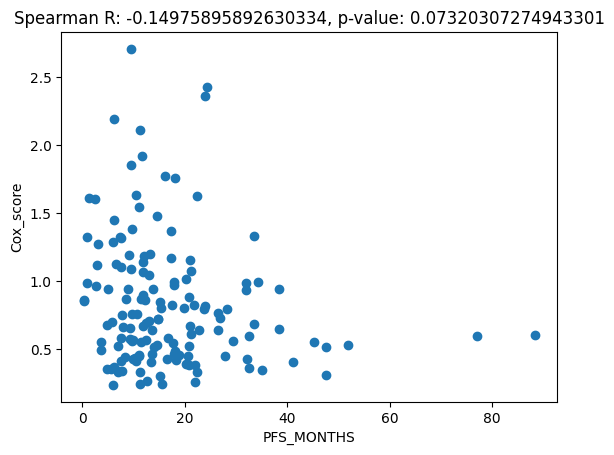

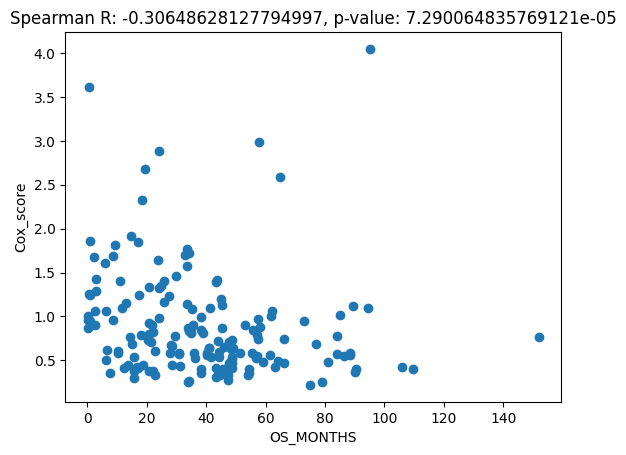

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

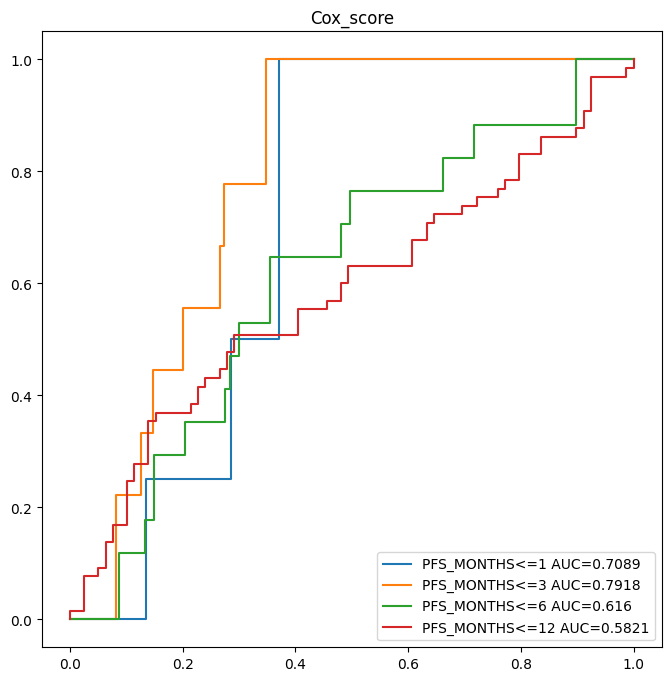

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

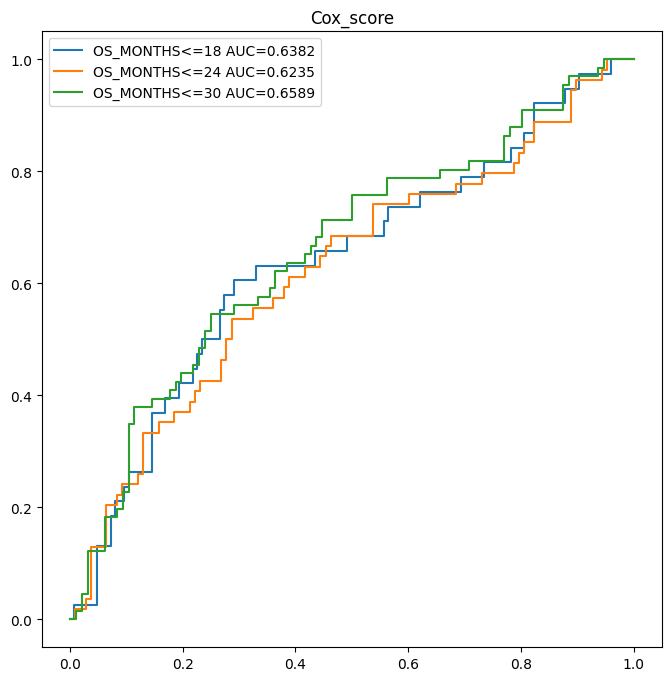

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

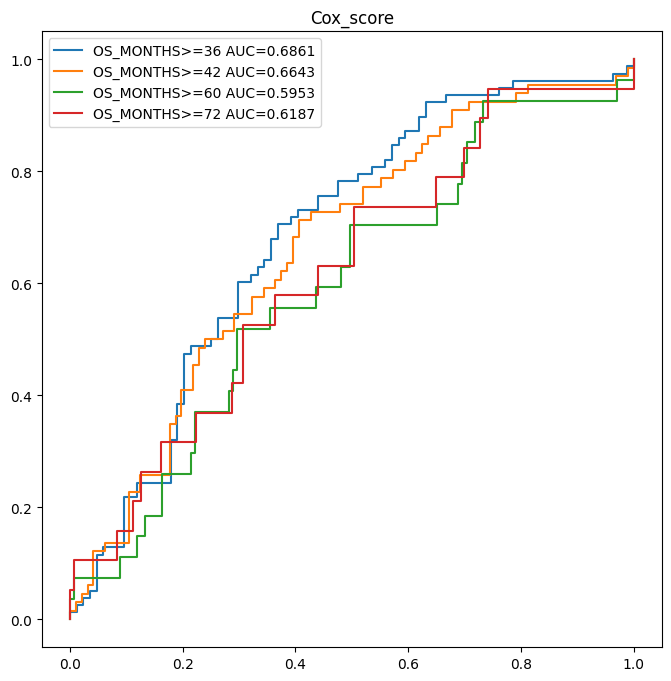

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -573.14
         time fit was run = 2023-11-28 20:11:01 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
H&E_score                            -1.83       0.16       1.04            -3.86             0.20                 0.02                 1.22

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  1.01 0.31       1.69
H&E_score                               0.00 -1.76 0.08       3.69
---
Concordance = 0.55
Partial AIC = 1150.27
log-likelihood ratio test = 3.84 on 2 df
-log2(p) of ll-ratio test = 2.77

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.008218   1.008252  0.008107   
H&E_score                           -1.828029   0.160730  1.035747   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.007672        0.024108   
H&E_score                                 -3.858056        0.201998   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.992357             1.024401   
H&E_score                                       0.021109             1.223845   

                                     cmp to         z         p  -log2(p)  
covariate                        

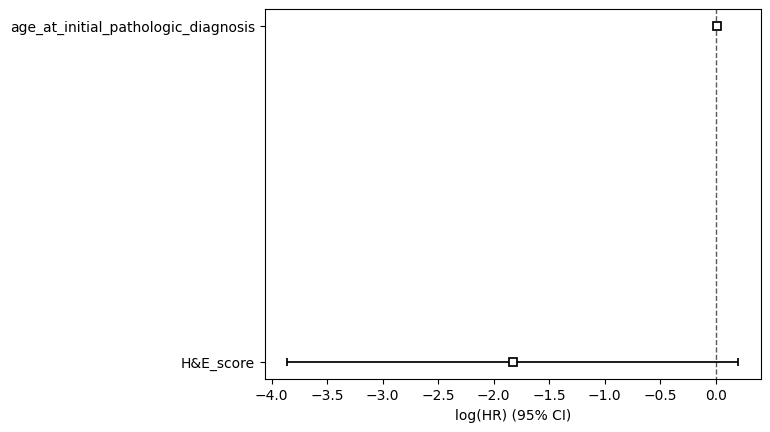

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -662.47
         time fit was run = 2023-11-28 20:11:01 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
H&E_score                            -1.26       0.28       0.88            -2.98             0.46                 0.05                 1.59

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  1.96 0.05       4.34
H&E_score                               0.00 -1.43 0.15       2.72
---
Concordance = 0.60
Partial AIC = 1328.94
log-likelihood ratio test = 6.37 on 2 df
-log2(p) of ll-ratio test = 4.59

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.014730   1.014839  0.007500   
H&E_score                           -1.257709   0.284305  0.877181   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.000030        0.029430   
H&E_score                                 -2.976952        0.461535   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.000030             1.029867   
H&E_score                                       0.050948             1.586507   

                                     cmp to         z         p  -log2(p)  
covariate                        

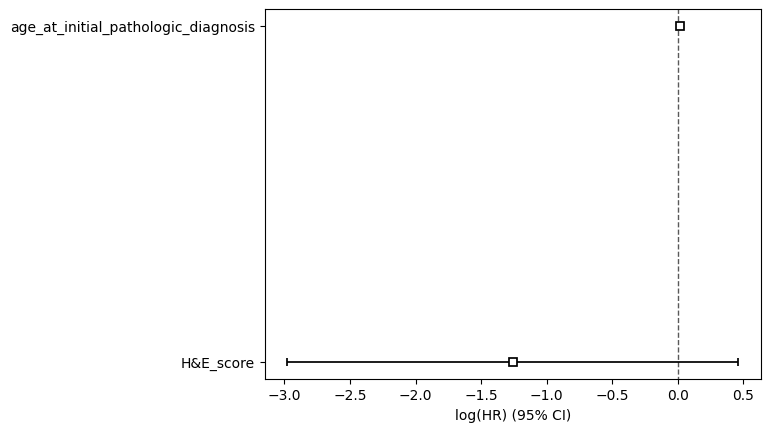

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -664.39
         time fit was run = 2023-11-28 20:11:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -1.43       0.24       0.88            -3.17             0.30                 0.04                 1.34

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.62 0.10       3.26
---
Concordance = 0.58
Partial AIC = 1330.78
log-likelihood ratio test = 2.53 on 1 df
-log2(p) of ll-ratio test = 3.16

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -1.434479    0.23824  0.882974       -3.165076        0.296119   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.042211              1.34463     0.0 -1.624599   

                  p  -log2(p)  
covariate                      
H&E_score  0.104248  3.261907  


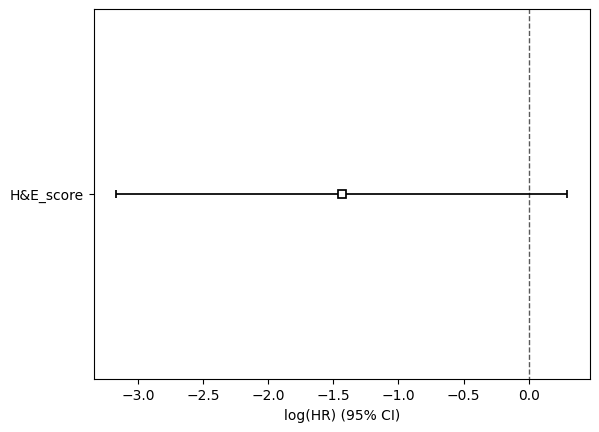

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -573.65
         time fit was run = 2023-11-28 20:11:01 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -1.77       0.17       1.04            -3.81             0.27                 0.02                 1.31

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.70 0.09       3.49
---
Concordance = 0.55
Partial AIC = 1149.30
log-likelihood ratio test = 2.82 on 1 df
-log2(p) of ll-ratio test = 3.42

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -1.768821   0.170534  1.040065       -3.807311        0.269668   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.022208             1.309529     0.0 -1.700684   

                  p  -log2(p)  
covariate                      
H&E_score  0.089002  3.490014  


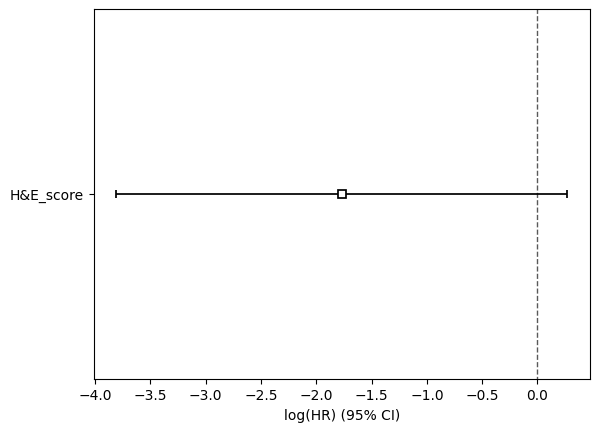

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -663.46
         time fit was run = 2023-11-28 20:11:01 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.10 0.04       4.79
---
Concordance = 0.57
Partial AIC = 1328.92
log-likelihood ratio test = 4.39 on 1 df
-log2(p) of ll-ratio test = 4.79

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.015597    1.01572  0.007439   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.001017        0.030178   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.001017             1.030638   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.096636  0.036026  4.794827  


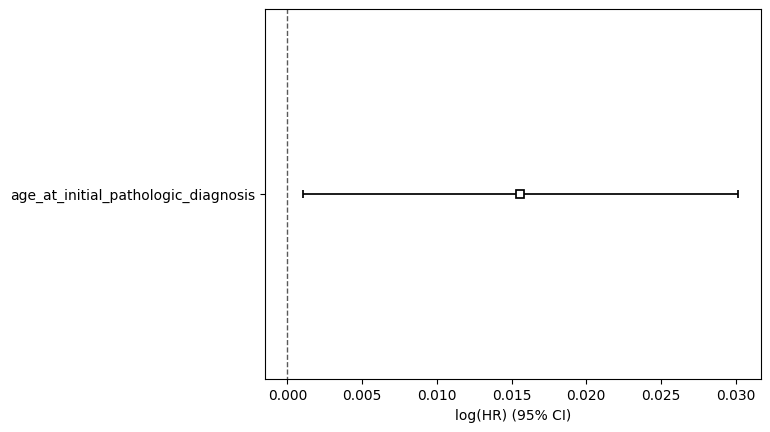

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -574.65
         time fit was run = 2023-11-28 20:11:01 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 0.90 0.37       1.45
---
Concordance = 0.52
Partial AIC = 1151.30
log-likelihood ratio test = 0.81 on 1 df
-log2(p) of ll-ratio test = 1.45

                                        coef  exp(coef)  se(coef)  \
covariate                                                           
age_at_initial_pathologic_diagnosis  0.00727   1.007296  0.008044   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.008497        0.023036   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.991539             1.023304   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  0.903719  0.366144  1.449516  


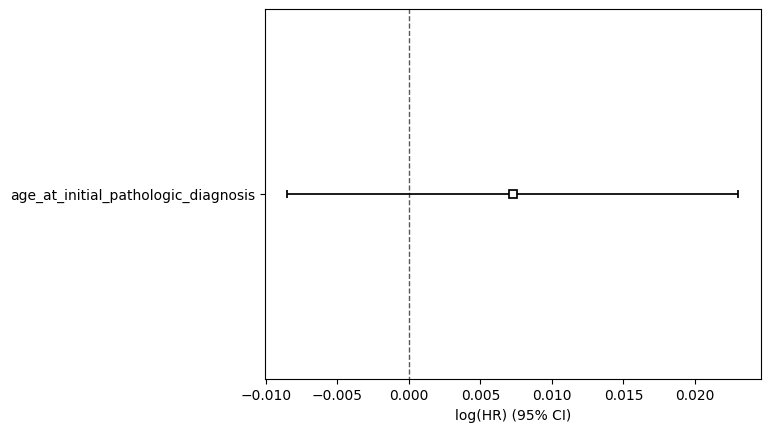

(<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>,
 <lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>)

In [214]:
model_performance(result_score_pfs_clinical, result_score_os_clinical, train_cox_pfs, train_cox_os)

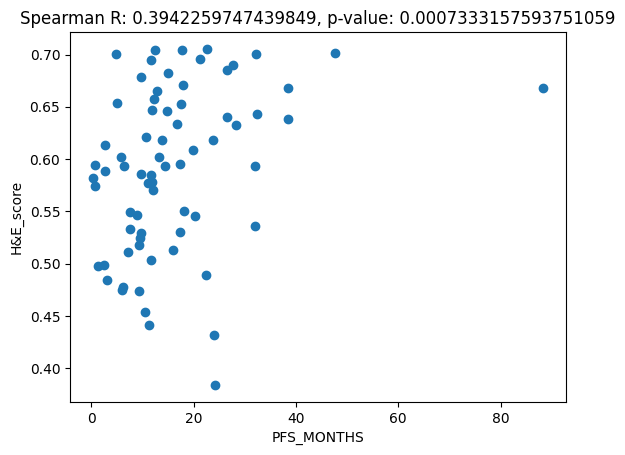

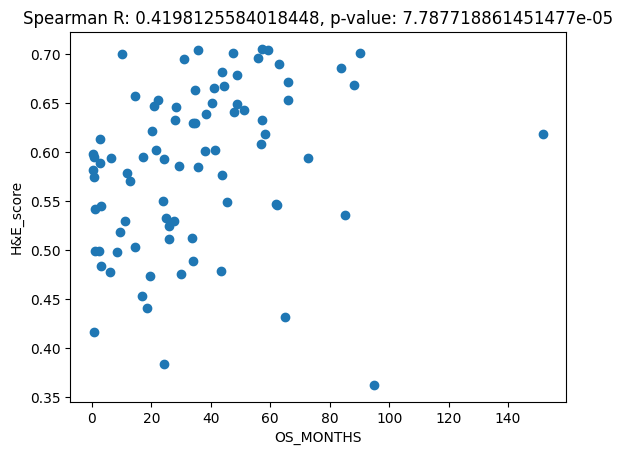

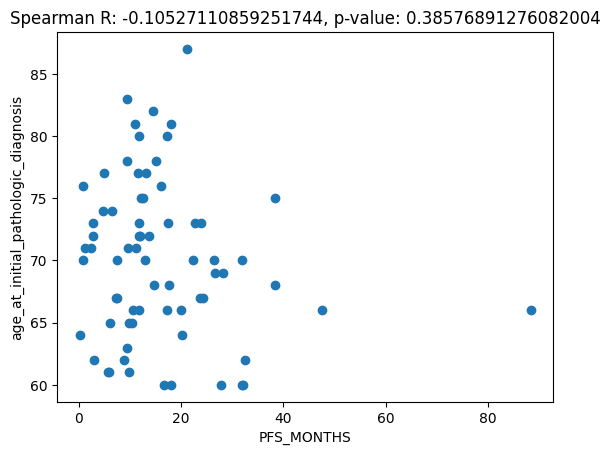

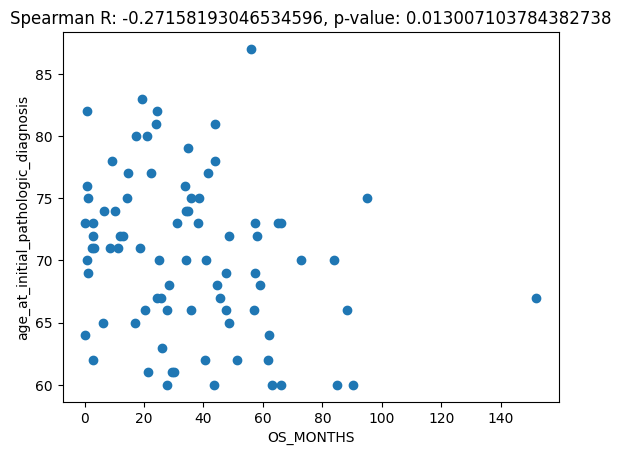

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

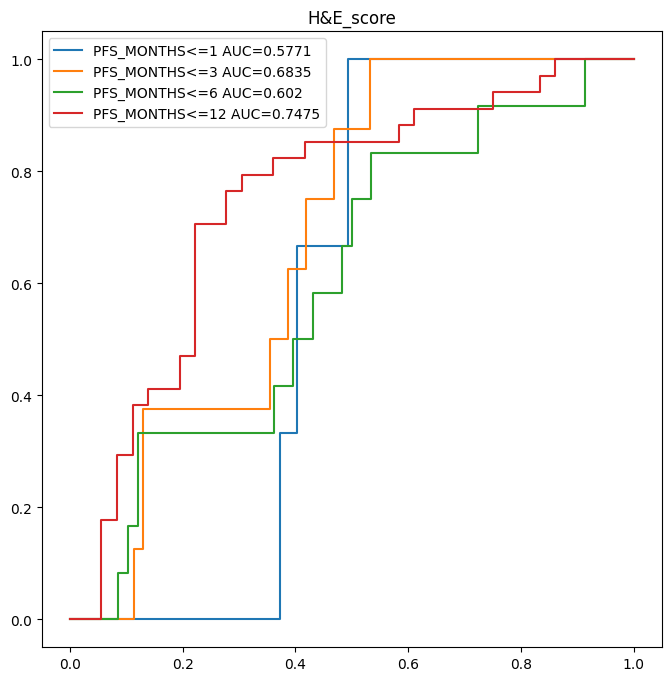

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

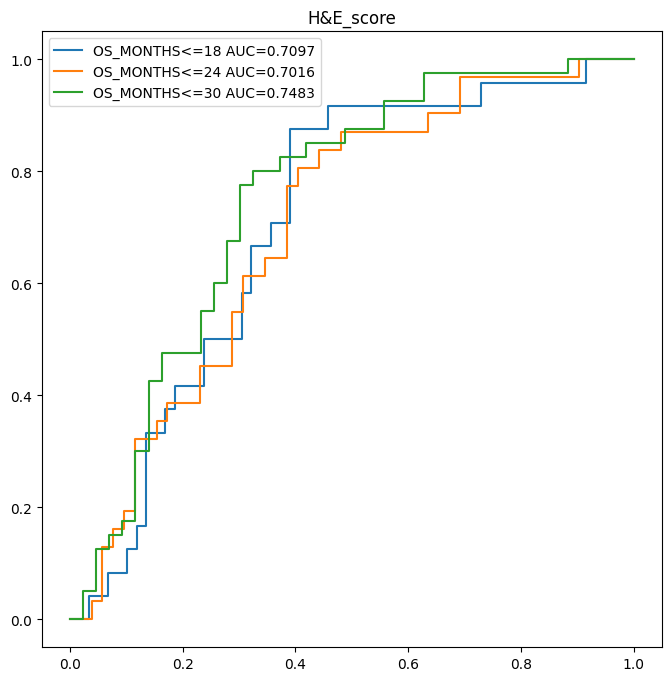

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

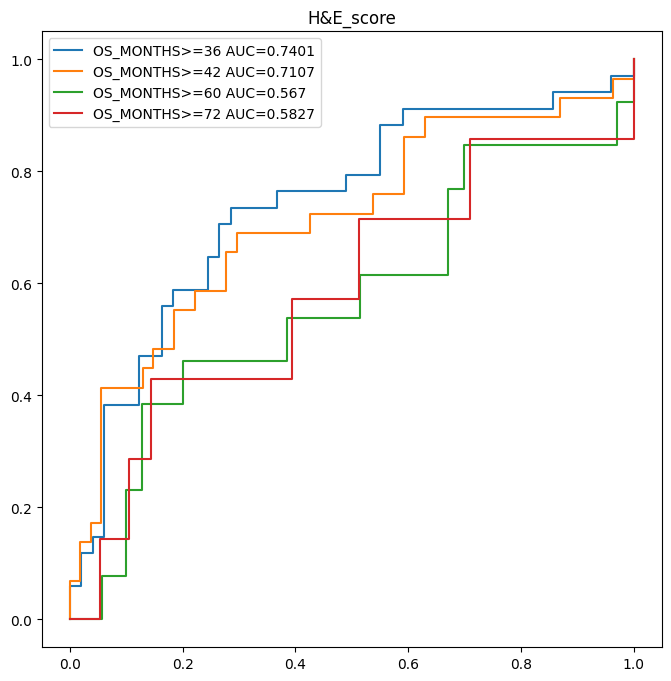

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

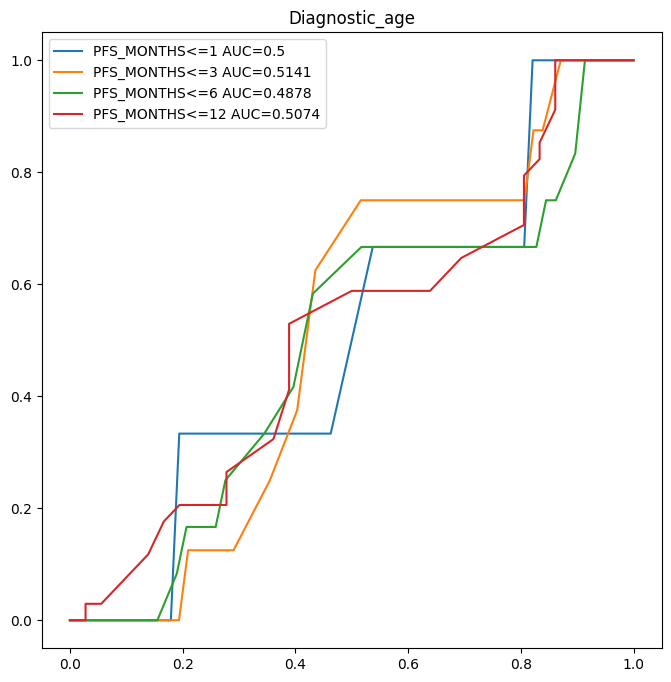

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

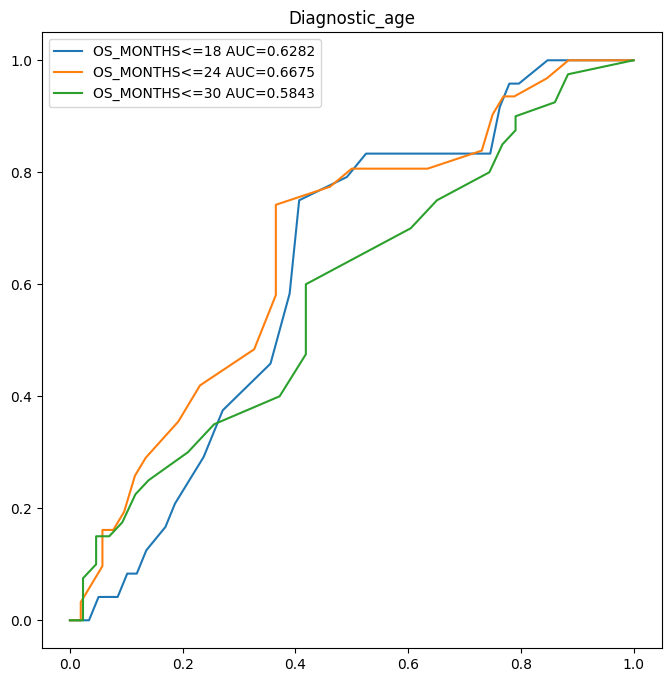

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

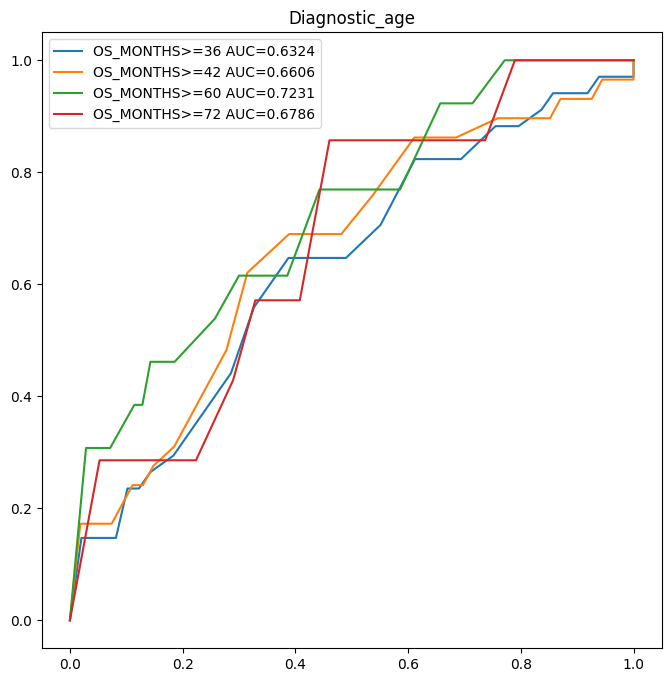

/tmp/ipykernel_113953/2759611059.py:163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_pfs['Cox_score'] = cox_pfs.predict_partial_hazard(df_with_score_and_pfs[['H&E_score','age_at_initial_pathologic_diagnosis']])
/tmp/ipykernel_113953/2759611059.py:164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_os['Cox_score'] = cox_os.predict_partial_hazard(df_with_score_and_os[['H&E_score','age_at_initial_pathologic_diagnosis']])


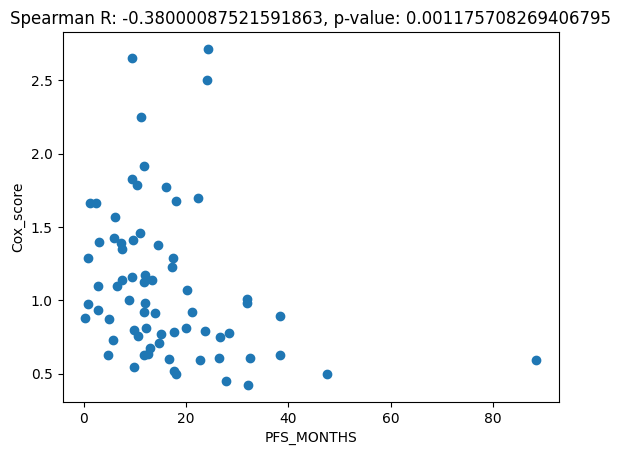

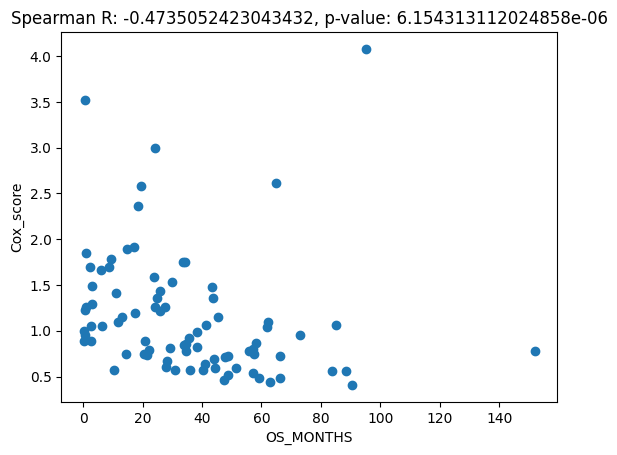

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

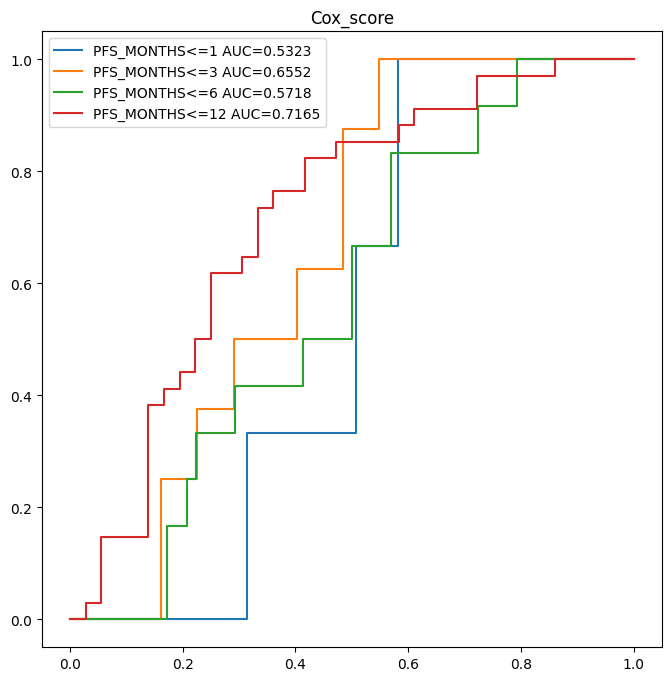

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

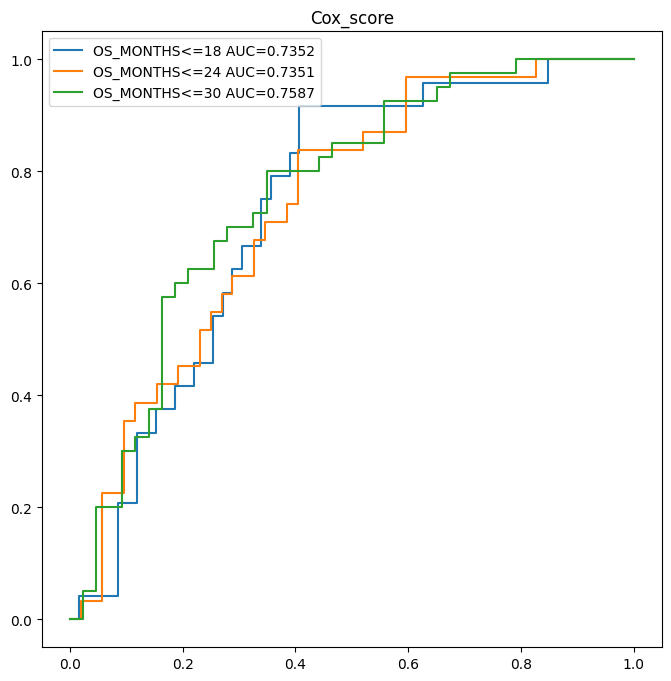

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

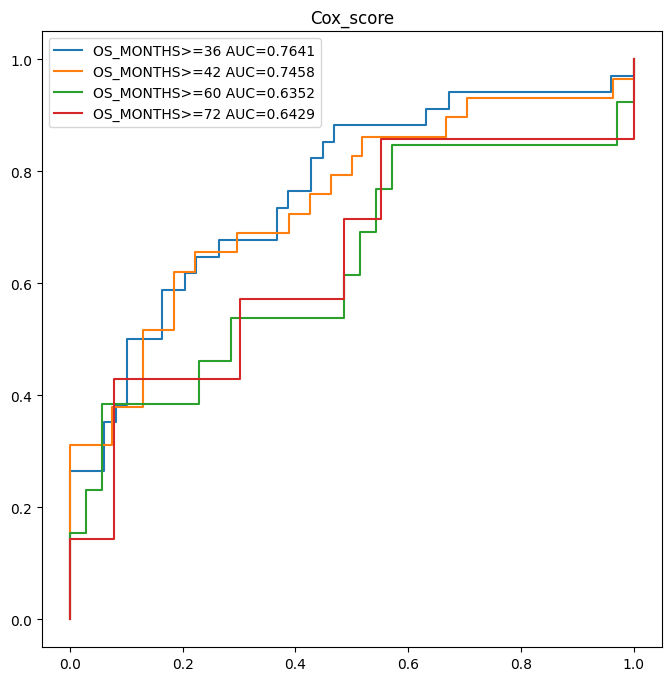

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -225.75
         time fit was run = 2023-11-28 20:46:59 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
H&E_score                            -3.93       0.02       1.39            -6.65            -1.20                 0.00                 0.30

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  1.38   0.17       2.57
H&E_score                               0.00 -2.82 <0.005       7.72
---
Concordance = 0.62
Partial AIC = 455.51
log-likelihood ratio test = 9.37 on 2 df
-log2(p) of ll-ratio test = 6.76

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.027025   1.027393  0.019640   
H&E_score                           -3.925663   0.019729  1.390123   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.011469        0.065519   
H&E_score                                 -6.650254       -1.201072   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.988596             1.067713   
H&E_score                                       0.001294             0.300871   

                                     cmp to         z         p  -log2(p)  
covariate                        

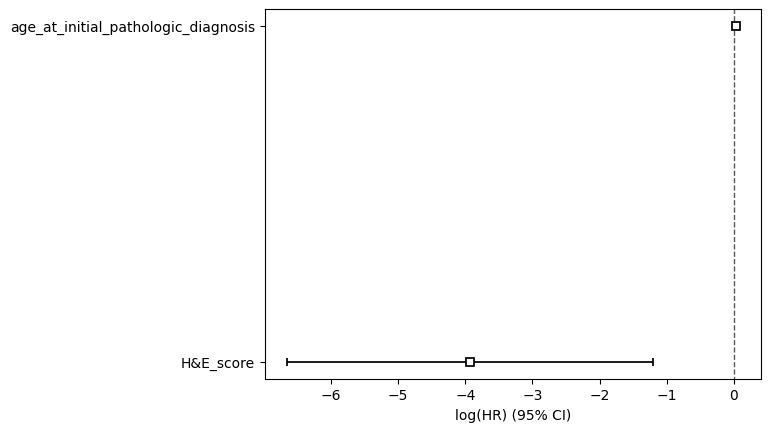

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -283.13
         time fit was run = 2023-11-28 20:46:59 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
H&E_score                            -1.75       0.17       1.13            -3.97             0.47                 0.02                 1.59

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  2.11 0.03       4.85
H&E_score                               0.00 -1.55 0.12       3.04
---
Concordance = 0.65
Partial AIC = 570.27
log-likelihood ratio test = 7.52 on 2 df
-log2(p) of ll-ratio test = 5.42

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.036644   1.037323  0.017347   
H&E_score                           -1.750574   0.173674  1.130986   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.002644        0.070644   
H&E_score                                 -3.967266        0.466118   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.002647             1.073199   
H&E_score                                       0.018925             1.593796   

                                     cmp to         z         p  -log2(p)  
covariate                        

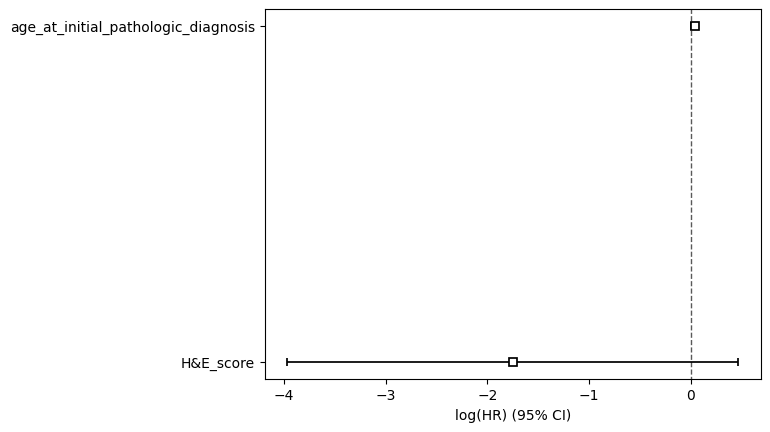

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -285.31
         time fit was run = 2023-11-28 20:46:59 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -2.09       0.12       1.14            -4.33             0.15                 0.01                 1.16

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.83 0.07       3.88
---
Concordance = 0.64
Partial AIC = 572.62
log-likelihood ratio test = 3.16 on 1 df
-log2(p) of ll-ratio test = 3.73

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -2.086774   0.124087  1.142388       -4.325813        0.152265   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.013223             1.164469     0.0 -1.826678   

                  p  -log2(p)  
covariate                      
H&E_score  0.067748  3.883672  


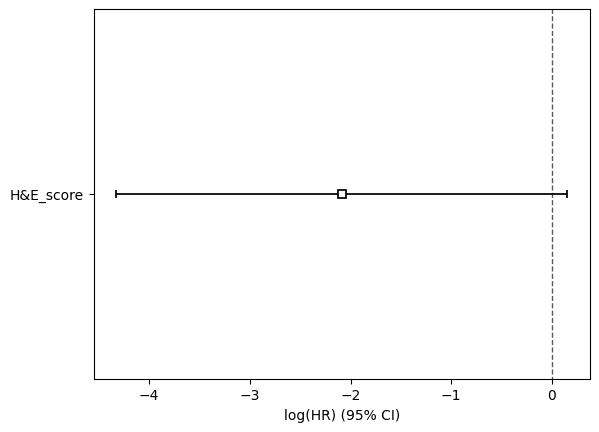

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -226.68
         time fit was run = 2023-11-28 20:47:00 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -3.93       0.02       1.38            -6.63            -1.22                 0.00                 0.29

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -2.85 <0.005       7.82
---
Concordance = 0.63
Partial AIC = 455.36
log-likelihood ratio test = 7.51 on 1 df
-log2(p) of ll-ratio test = 7.35

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -3.928799   0.019667  1.379872       -6.633298         -1.2243   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z        p  \
covariate                                                                       
H&E_score             0.001316             0.293963     0.0 -2.84722  0.00441   

           -log2(p)  
covariate            
H&E_score  7.824912  


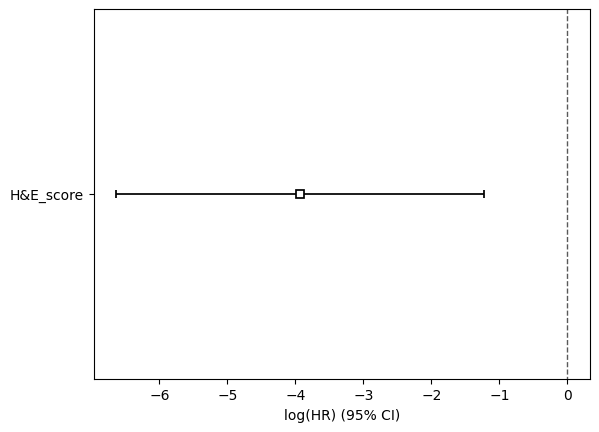

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -284.28
         time fit was run = 2023-11-28 20:47:00 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.04       1.04       0.02             0.01             0.07                 1.01                 1.08

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.32 0.02       5.60
---
Concordance = 0.59
Partial AIC = 570.57
log-likelihood ratio test = 5.22 on 1 df
-log2(p) of ll-ratio test = 5.48

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.039414   1.040201   0.01702   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.006055        0.072773   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.006073             1.075486   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.315703  0.020574  5.602999  


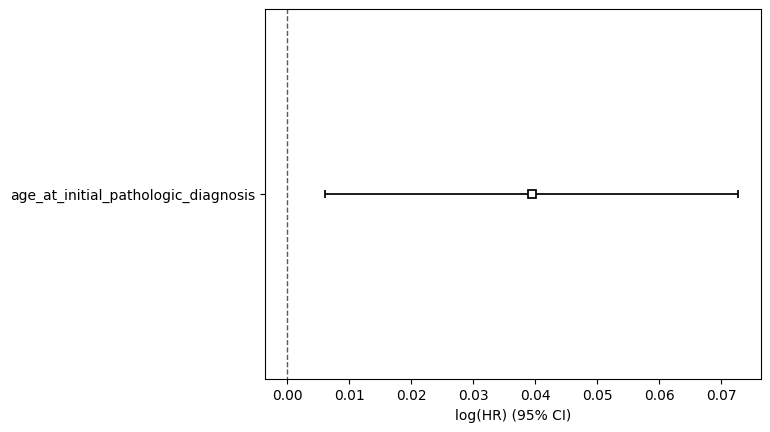

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -229.46
         time fit was run = 2023-11-28 20:47:00 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.02            -0.01             0.06                 0.99                 1.07

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.42 0.16       2.67
---
Concordance = 0.53
Partial AIC = 460.92
log-likelihood ratio test = 1.96 on 1 df
-log2(p) of ll-ratio test = 2.63

                                        coef  exp(coef)  se(coef)  \
covariate                                                           
age_at_initial_pathologic_diagnosis  0.02683   1.027193  0.018951   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.010314        0.063974   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.989739             1.066065   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.415732  0.156854  2.672505  


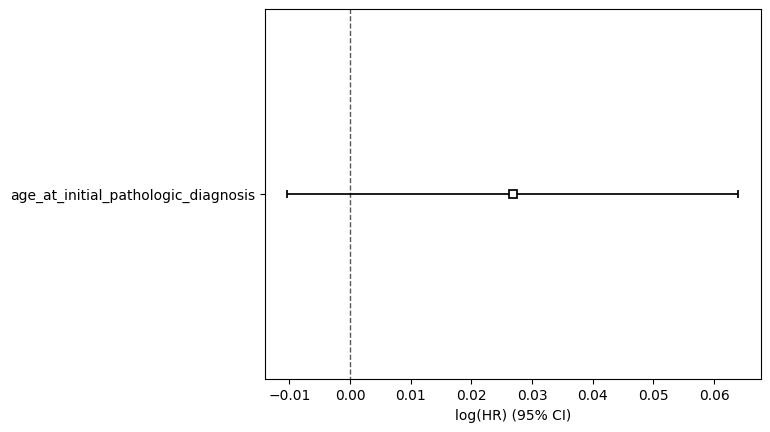

(<lifelines.CoxPHFitter: fitted with 154 total observations, 0 right-censored observations>,
 <lifelines.CoxPHFitter: fitted with 129 total observations, 0 right-censored observations>)

In [224]:
model_performance(result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60], result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60], train_cox_pfs, train_cox_os)

70.0


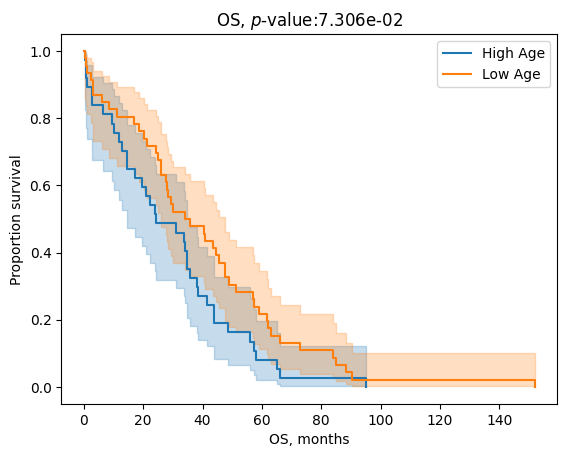

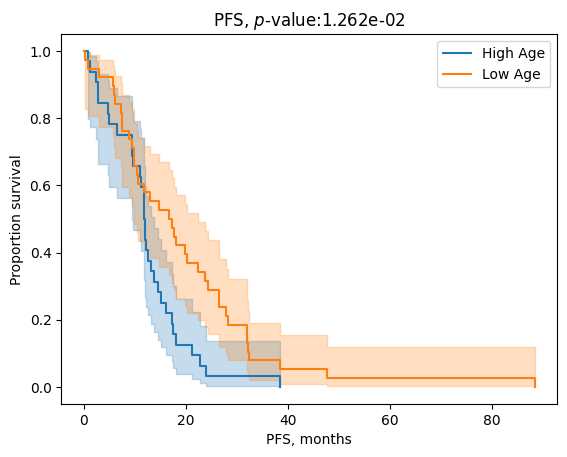

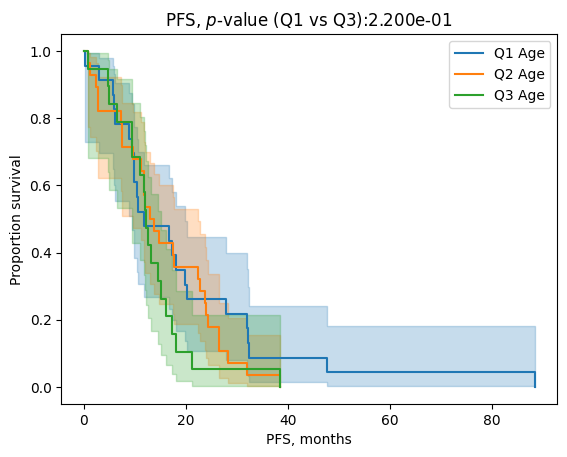

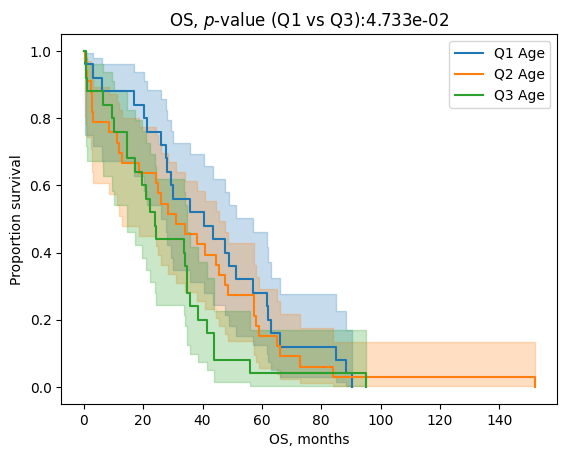

In [216]:
kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'age_at_initial_pathologic_diagnosis')

0.594153356552124


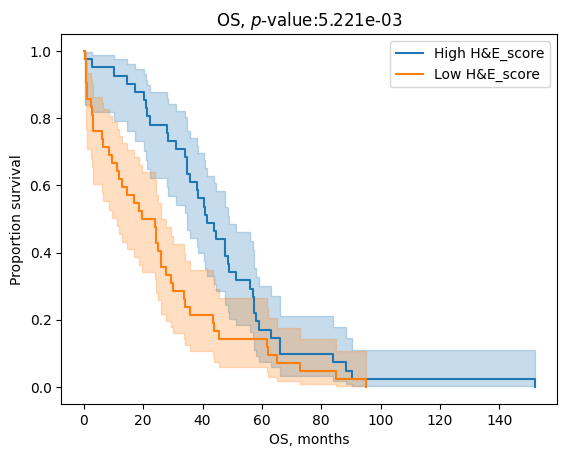

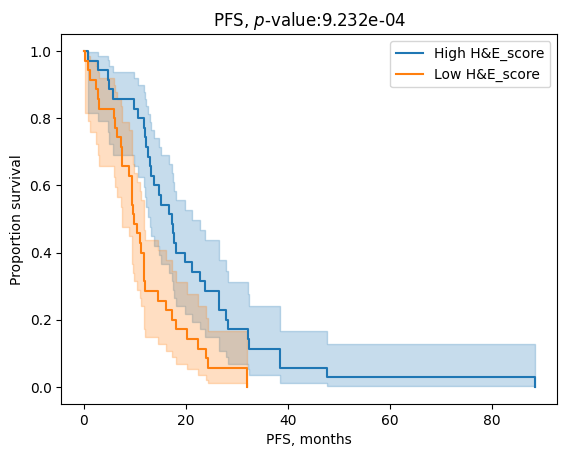

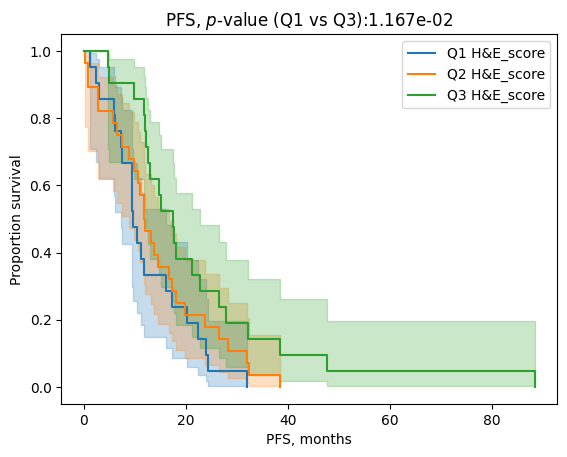

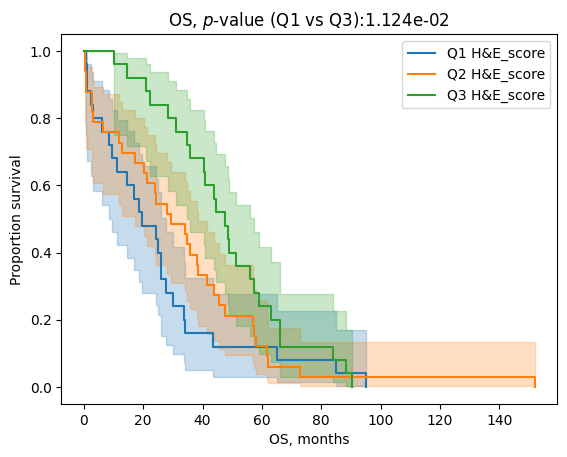

In [217]:
kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'H&E_score')

0.972092925685399


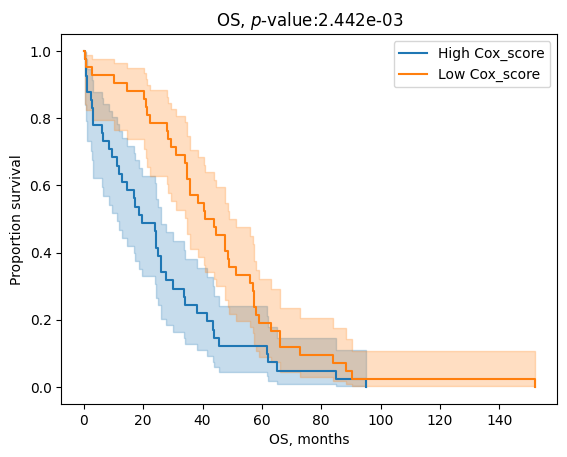

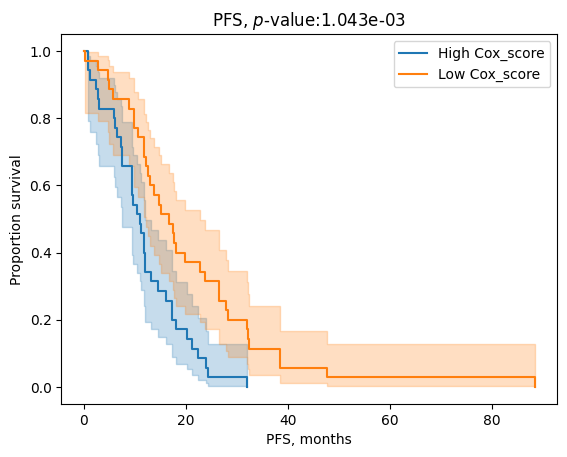

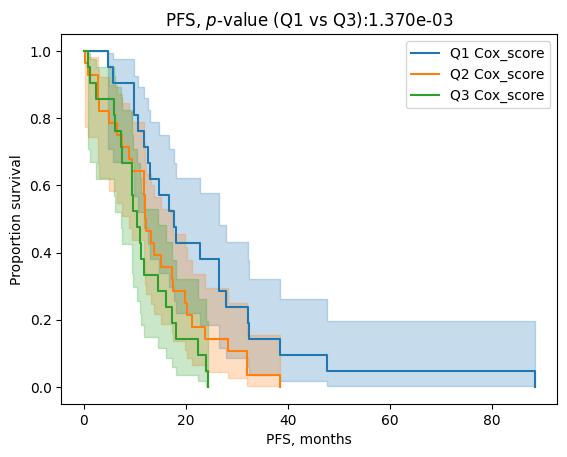

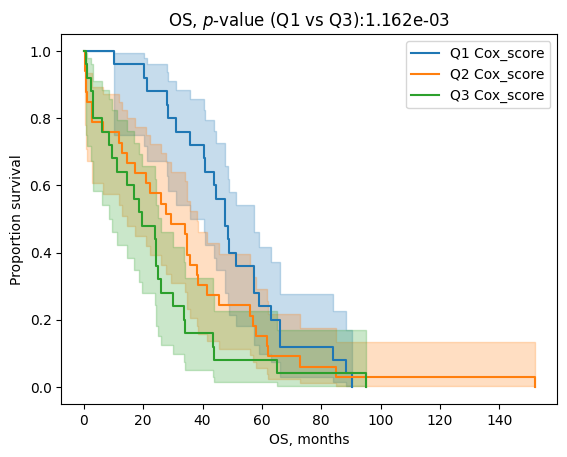

In [218]:
kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'Cox_score')

In [85]:
import torchvision.utils as utils
import cv2

def visualize_attention(I_train,a,up_factor,no_attention=False):
    import torch.nn.functional as F
    img = I_train.permute((1,2,0)).cpu().numpy()
    # compute the heatmap
#     if up_factor > 1:
    a = F.interpolate(a, scale_factor=up_factor, mode='bilinear', align_corners=False)
    attn = utils.make_grid(a, nrow=6, normalize=True, scale_each=True)
    attn = attn.permute((1,2,0)).mul(255).byte().cpu().numpy()
    attn = cv2.applyColorMap(attn, cv2.COLORMAP_JET)
    attn = cv2.cvtColor(attn, cv2.COLOR_BGR2RGB)
    attn = np.float32(attn) / 255
    # add the heatmap to the image
#     img=cv2.resize(img,(176,60))
    if no_attention:
        return torch.from_numpy(img)
    else:
        vis = 0.6 * img + 0.4 * attn
        return torch.from_numpy(vis)

In [93]:
def attention_visualization(model_path, dataloader):
    import torch.nn.functional as F
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model_test = Model.Net().to(device)
    model_test.load_state_dict(checkpoint['model_state_dict'])
    model_test.cuda()
    criterion = nn.CrossEntropyLoss()
    epoch_test = checkpoint['epoch']
    loss_test = checkpoint['loss']
    model_test.eval()

    loss_epoch_test=[]
    y_proba = []
    y_layers = []
    y_gold = []
    y_pred = []
    with torch.no_grad():
        for b, (X, y) in enumerate(dataloader):
            I_train = utils.make_grid(X[0:6,:,:,:], nrow=len(X), normalize=True, scale_each=True)
            outputs, a1, a2 = model_test(X.cuda())
            orig=visualize_attention(I_train,a1,up_factor=2,no_attention=True)
    #         first=visualize_attention(I_train,a1,up_factor=4,no_attention=False)
            first=visualize_attention(I_train,a2,up_factor=16,no_attention=False)
            fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10, 10))
            ax1.imshow(orig)
            ax2.imshow(first)
            ax1.title.set_text('Input')
            ax2.title.set_text('Module2')
            plt.show()
            break

['../Data/9f9d8f37-855c-4878-a7f2-3dec6055dffd/TCGA-23-1124-01A-01-BS1.bce719cf-462c-418c-8646-c52770efe5e0.svs-1.jpg'] [1]


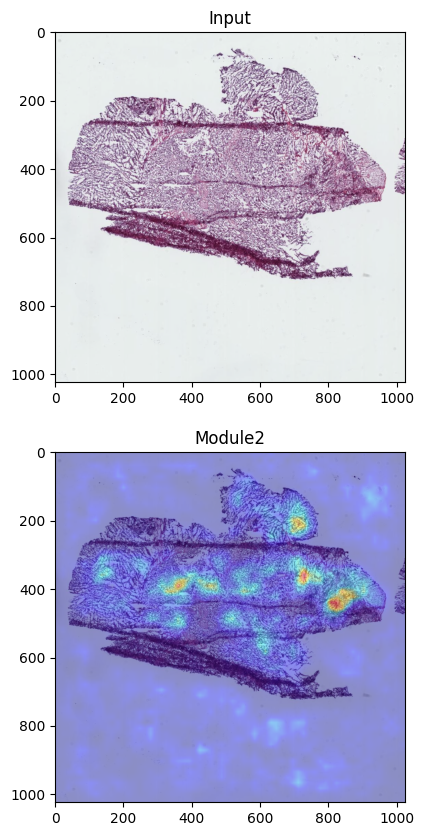

In [96]:
model_path_0 = folder + "/0/" + os.listdir(folder+'/0')[-1]

i=1
print([X_train[i]], [y_train.iloc[i]])
visualize_dataset = Dataset.MyData_test([X_train[i]], [y_train.iloc[i]])
visualize_dataloader = DataLoader(visualize_dataset,batch_size=1,shuffle=False)

attention_visualization(model_path_0, visualize_dataloader)